# Final Project: ICU LOS Predictive Model

### Objective
  1. Create a predictive model to forecast the length of stay in the hospital's critical care units, otherwise known as Intensive Care Unit (ICU), for patients prone to readmission.

### Modeling Approach
An array of Random Forest sub-models tailored to disease groups. The composite dataset (after feature extraction) is stratified based on the disease organ system, grouping similar diseases. Weak performing disease groups are further stratified into *surgical* and *medical* sub-groups.

In [243]:
import psycopg2
from psycopg2 import extras
import sys, os
import numpy as np
import pandas as pd
from scipy import stats
import itertools
from sklearn import grid_search
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
def cursor_connect(cursor_factory=None):
    """
    Connects to the DB and returns the connection and cursor, ready to use.
    
    Parameters
    ----------
    cursor_factory : psycopg2.extras
    
    Returns
    -------
    (psycopg2.extensions.connection, psycopg2.extensions.cursor)
        A tuple of (psycopg2 connection, psycopg2 cursor).
    """
    #DB connection
    conn = psycopg2.connect(dbname="mimic", user="mimic", host="172.31.28.5",
                            password="mimic")
    if not cursor_factory:
        cur = conn.cursor()
    else:
        cur = conn.cursor(cursor_factory=cursor_factory)
    return conn, cur

def exec_query(query, curs_dict=False):
    """
    Execute query and returns the SQL output.
    
    Parameters
    ----------
    query: string containing SQL SELECT command
    curs_dict: dict cursor factory (output is dict)
    
    Returns
    -------
    rows: list of rows/records (SQL output)
    """
    if curs_dict == True: 
        conn, cur = cursor_connect(psycopg2.extras.DictCursor)
    else:
        conn, cur = cursor_connect()
    cur.execute('SET search_path TO mimiciii;')
    cur.execute(query)
    rows = cur.fetchall()
    return rows

# Dataset

## Interval: 30 Days
Patients' ICU admissions within the last 30 days from the current ICU stay.

## Exclusion Criteria
1. Minors
2. No Readmissions

## Features (`X`)

### Operations
* **`subjectid`**: subject ID of patients
* **`icustayid`**: ID of a unique ICU stay
* **`readm_days`**: number of days since discharge of previous ICU stay
* **`prev_iculos`**: total length of stay (LOS) of the previous unique ICU stay
* **`age`**: age of patient at the times of ICU admission
* **`ethnicity`**: categorical feature indicating ethnicity group
* **`marital_status`**: categorical feature indicating marital status.
* **`insurance`**: categorical feature indicating insurance type.
* **`NonEnglish`**: binary feature indicating non-english speaker.
* **`N`<sub>icutrav</sub>**: the number of total intra-ICU ward transfers (non-unique ICU stays)
* **`prev_cu`**: categorical feature indicating previous care unit
* **`curr_cu`**: categorical feature indicating current care unit
* **`prev_ICU`**: binary feature indicating if previous care unit was an ICU type
* **`disch_cu`**: categorical feature indicating discharge care unit from ICU stay
* **`disch_ICU`**: binary feature indicating if discharge care unit was an ICU type
* **`icu_in_day`**: time of ICU admission (day/night)
* **`icu_out_day`**: time of ICU discharge (day/night)
* **`readm_risk`**: risk score of intra-patient unique ICU readmissions
* Transfer Pairs
    * **`nonicu-MICU`**	
    * **`nonicu-SICU`**	
    * **`nonicu-TSICU`**	
    * **`nonicu-CSRU`**	
    * **`MICU-MICU`**	
    * **`TSICU-TSICU`**	
    * **`nonicu-CCU`**	
    * **`CCU-CCU`**
    * **`CSRU-CSRU`**	
    * **`SICU-SICU`**	
    
### Clinical
  * **Surgical Patients**: binary feature indicating the presence of surgery during an ICU stay 
  * **Abnormal Hemoglobin**: binary feature indicating the presence of abnormal hemoglobin results
  * **HADM Procedures**: series of binary features indicating presence of procedures during hospital admission.
  
**Note**: Clinical features were obtained from Luyan's work. Please refer to her IPython notebook's for further information and details on their processing and extraction.
 
## Dependent Variables/Response (`Y`) 
  * **`icu_los`**: ICU length of stay

### Unique ICU stays

Features:
  * **`subjectid`**: subject ID of patients
  * **`icustaysid`**: ID of a unique ICU stay
  * **`readm_days`**: number of days since discharge of previous ICU stay to admission of current ICU stay (ICU readmission)

In [3]:
def prev_icutime(data):
    """
    Helper function determining time of the previous ICU discharge/transfer.
    
    :param data: pandas DataFrame
    :return: pandas Series 
    """
    if data['readm_days'] == np.nan:
        pass
    else:
        prev_icutime = data['icu_intime'] - data['readm_days'] # time of previous ICU discharge/transfer
        return prev_icutime

In [4]:
# query
q_icustay="""SELECT subject_id, hadm_id, icustay_id, min_in, max_out,
min_in - lag(max_out)
OVER (PARTITION BY subject_id ORDER BY min_in) AS diff
FROM
(SELECT subject_id, hadm_id, icustay_id, 
MIN(intime) as min_in, MAX(outtime) AS max_out
FROM transfers
WHERE icustay_id IS NOT NULL
GROUP BY subject_id, hadm_id, icustay_id) as sub_q
ORDER BY subject_id
"""

# Query output
icustay = exec_query(q_icustay)
df_icustay = pd.DataFrame(icustay, columns=['subjectid', 'hadmid', 'icustayid', 
                                            'icu_intime', # first unique ICU admission time 
                                            'icu_outtime', #  unique ICU discharge time
                                            'readm_days']) # number of days since last ICU discharge/transfer

df_icustay['icu_prev_outtime'] = df_icustay.apply(prev_icutime, axis=1) # previous icu stay time
df_icustay.readm_days.dropna(inplace=True)
df_icustay['readm_days'] = np.round(df_icustay['readm_days'].astype(int) * (1/8.64e13), 3) # convert to units of days
print df_icustay.shape
df_icustay.head()

(61532, 7)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,icu_prev_outtime
0,2,163353,243653,2138-07-17 21:20:07,2138-07-17 23:32:21,NaN,NaT
1,3,145834,211552,2101-10-20 19:10:11,2101-10-26 20:43:09,NaN,NaT
2,4,185777,294638,2191-03-16 00:29:31,2191-03-17 16:46:31,NaN,NaT
3,5,178980,214757,2103-02-02 06:04:24,2103-02-02 08:06:00,NaN,NaT
4,6,107064,228232,2175-05-30 21:30:54,2175-06-03 13:39:54,NaN,NaT


Filter for patients with ICU readmissions.

In [5]:
# query
q_readm_pat ="""SELECT * FROM
    (SELECT subject_id, COUNT(icustay_id) AS n_icustays
    FROM icustays
    GROUP BY subject_id) AS sub_q
WHERE n_icustays > 1;"""

# Query output
readm_pat = exec_query(q_readm_pat, False)
df_readm_pat = pd.DataFrame(readm_pat, columns=['subjectid', 'n_icustays']) # patient w/ ICU readmissions (multiple)

df_readm = df_icustay[df_icustay['subjectid'].isin(df_readm_pat.subjectid)] # filter patients w/ ICU readmissions
print df_readm.shape
df_readm.head()

(23811, 7)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,icu_prev_outtime
5,7,118037,278444,2121-05-23 15:35:29,2121-05-23 22:01:00,NaN,NaT
6,7,118037,236754,2121-05-25 03:26:01,2121-05-25 21:10:19,1.226,2121-05-23 22:01:00
14,17,194023,277042,2134-12-27 16:21:48,2134-12-29 18:04:03,NaN,NaT
15,17,161087,257980,2135-05-09 14:12:06,2135-05-10 11:18:34,130.839,2134-12-29 18:04:03
19,21,109451,217847,2134-09-11 20:50:04,2134-09-17 18:28:32,NaN,NaT


Extract prior ICUstay ID through `icu_prior_outtime`.

**Note**: Some ICUstays have duplicate entries (use of `DISTINCT ON` prevents duplicates)

In [6]:
q_previcu = """SELECT DISTINCT ON (subject_id, icustay_id, outtime) subject_id, icustay_id, outtime 
FROM transfers 
WHERE icustay_id IS NOT NULL;
"""
# Query output
prev_icustay = exec_query(q_previcu)
df_previcu = pd.DataFrame(prev_icustay, columns=['subjectid', 'prev_icustayid', 'icu_prev_outtime']) # ID of previous ICU stay

df_readm = pd.merge(df_readm, df_previcu, on=['subjectid', 'icu_prev_outtime'], how='left')
df_readm.drop(labels='icu_prev_outtime', axis=1, inplace=True)
df_readm.head()

,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid
0,7,118037,278444,2121-05-23 15:35:29,2121-05-23 22:01:00,NaN,NaN
1,7,118037,236754,2121-05-25 03:26:01,2121-05-25 21:10:19,1.226,278444.0
2,17,194023,277042,2134-12-27 16:21:48,2134-12-29 18:04:03,NaN,NaN
3,17,161087,257980,2135-05-09 14:12:06,2135-05-10 11:18:34,130.839,277042.0
4,21,109451,217847,2134-09-11 20:50:04,2134-09-17 18:28:32,NaN,NaN


## Exclusion

#### Neonate Patients

In [7]:
q_nicu = """SELECT DISTINCT icustay_id FROM transfers              
WHERE curr_careunit = 'NICU' AND icustay_id IS NOT NULL;
"""
nicu_stays = exec_query(q_nicu)
df_nicu_stays = pd.DataFrame(nicu_stays, columns=['icustayid'])

df_readm = df_readm[df_readm['icustayid'].isin(df_nicu_stays.icustayid)==False] # filter for non-neonate patients
df_readm.shape

(23357, 7)

#### Minors
Note: Patients' age must be readjusted for those age > 89 per MIMIC-III documentation. The dataset adjusts the values of older patients.

In [8]:
# age of patients < 90
q_age_hadm1 = """SELECT a.subject_id,
    FLOOR((a.admittime::date - p.dob::date)/365.0) AS age
    FROM admissions as a
    INNER JOIN patients as p
    ON a.subject_id = p.subject_id
    WHERE FLOOR((a.admittime::date - p.dob::date)/365.0) < 90;"""

# adjusted age of patients > 89
q_age_hadm2 = """SELECT a.subject_id,
    FLOOR((a.admittime::date - p.dob::date)/365.0) -210 AS age
    FROM admissions as a
    INNER JOIN patients as p
    ON a.subject_id = p.subject_id
    WHERE FLOOR((a.admittime::date - p.dob::date)/365.0) > 89;"""

age_hadm1 = exec_query(q_age_hadm1, False) 
age_hadm2 = exec_query(q_age_hadm2, False) # patients > 89 yrs old requiring adjustment
df_age_hadm1 = pd.DataFrame(age_hadm1, columns=['subjectid', 'age'])
df_age_hadm2 = pd.DataFrame(age_hadm2, columns=['subjectid', 'age'])

df_age_hadm = pd.concat([df_age_hadm1, df_age_hadm2]) # patient age dataframe
df_adults = df_age_hadm[df_age_hadm.age > 17] # filter for adults
df_adults_sid = list(df_adults.subjectid.value_counts().index.sort_values()) # list of subject IDs

df_readm = df_readm[df_readm.subjectid.isin(df_adults_sid)]
df_readm.shape

(23353, 7)

## Dataset Interval/Period 

### Count for each Cutoff
Cutoff for days between last ICU stay discharge and current ICU admission.

In [9]:
count_disch = dict()
for elem in [30, 60, 90, 120, 150, 180]:
    count_disch[elem] = df_readm[df_readm.readm_days <= elem].shape[0]

df_count = pd.DataFrame.from_dict(count_disch, orient='index').reset_index()
df_count.columns = ['days_cutoff', 'count']
df_count.sort_values('days_cutoff', ascending=True)

,days_cutoff,count
5,30,6161
4,60,7626
3,90,8494
2,120,9061
1,150,9525
0,180,9914


### Interval: 30 Days

In [10]:
period = 30
df_readm = df_readm[df_readm['readm_days'] <= period]

### Previous ICU LOS
The total LOS of the previous unique ICU stay, *includes the duration of all intra-ICU stays*.

In [11]:
q_prevlos = """SELECT icustay_id, los 
FROM icustays;"""

prevlos = exec_query(q_prevlos)
df_prevlos = pd.DataFrame(prevlos, columns=['prev_icustayid', 'prev_iculos'])

df_readm1 = pd.merge(df_readm, df_prevlos, on='prev_icustayid', how='left')

print df_readm1.shape
df_readm1.head()

(6161, 8)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965


### Age
Age of times at the time of ICU admission.

**Notes**: 
  * Patients may have different age, depending on the time of admission.
  * MIMIC-III adjusts age of patients > 89 years old (+ 210 years)

In [12]:
def age_adj(age):
    """Helper function adjust patients age per MIMIC-III documentation.
    
    :param age: integer 
    :return: integer
    """
    if age > 89:
        return age - 210
    else:
        return age

In [13]:
q_age = """SELECT DISTINCT subject_id, dob FROM patients;"""

age = exec_query(q_age) # query output
df_age = pd.DataFrame(age, columns=['subjectid', 'dob'])

df_readm2 = pd.merge(df_readm1, df_age, on='subjectid', how='left')

# Calculate age
age = df_readm2.icu_intime.values.astype('datetime64[D]') - df_readm2.dob.values.astype('datetime64[D]')
age = age / 365
df_readm2['age'] = age.astype(int)
df_readm2['age'] = df_readm2.age.apply(age_adj)

df_readm2 = df_readm2[df_readm2.age > 17]
df_readm2.drop('dob', axis=1, inplace=True)

print df_readm2.shape
df_readm2.head()

(6161, 9)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81


### Ethnicity
Ethnicity of the patients.

Legend:
  * `0`: Asian
  * `1`: Black
  * `2`: Hispanic
  * `3`: White
  * `4`: Other
  * `5`: N/A

**Notes**:
  * Prior exploratory data analyses found that African-Americans were the leading group for being prone to ICU readmissions.  85% of their group were readmitted into the ICU.
  * Dataset provides many specific ethnicity categories, thus providing little sample size when grouping the data by ethnicity. The feature/column has been processed in order to bin the data into more broad ethnicity categorizations.
    * Ethnicity na accounts for data unable to be collected or declined by patients.

In [14]:
def overall_ethn(ethn):
    """Helper function binning patients' ethnicity into broader level classification.
    
    :param ethn: string 
    :return: lower-case string
    """
    if 'hispanic' in ethn.lower():
        new_ethn = 'hispanic'
    elif 'asian' in ethn.lower() or 'pacific islander' in ethn.lower():
        new_ethn = 'asian'
    elif 'white' in ethn.lower():
        new_ethn = 'white'
    elif 'black' in ethn.lower():
        new_ethn = 'black'
    elif 'decline' in ethn.lower() or 'unable' in ethn.lower():
        new_ethn = 'na'
    else:
        new_ethn = 'other'
    return new_ethn

In [15]:
q_ethn = """SELECT DISTINCT ON (subject_id) subject_id, ethnicity 
FROM admissions;"""

ethnicity = exec_query(q_ethn) # query output
df_ethn = pd.DataFrame(ethnicity, columns=['subjectid', 'ethnicity'])

df_readm3 = pd.merge(df_readm2, df_ethn, on='subjectid', how='left')
df_readm3['ethnicity'] = df_readm3.ethnicity.apply(overall_ethn)
df_readm3['ethnicity'].replace(to_replace = 
                               {'asian': 0, 'black':1, 'hispanic': 2,
                               'white': 3, 'other': 4, 'na': 5}, inplace=True) # create numerical category values

print df_readm3.shape
df_readm3.head()

(6161, 10)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3


### Marital Status
Martial status of the patients.

Legend:
  * `0`: Single
  * `1`: Married
  * `2`: Divorced
  * `3`: Separated
  * `4`: Widowed
  * `5`: Life Partner
  * `6`: Unknown (*default*)

In [16]:
q_marital = """SELECT DISTINCT ON (subject_id, hadm_id) subject_id, 
hadm_id, marital_status 
FROM admissions;"""

marital_status = exec_query(q_marital) # query output
df_marital = pd.DataFrame(marital_status, 
                          columns=['subjectid', 'hadmid', 'marital_status'])

df_readm4 = pd.merge(df_readm3, df_marital, on=['subjectid', 'hadmid'], how='left')
df_readm4['marital_status'].replace(to_replace = 
                                   {'SINGLE': 0, 'MARRIED':1, 'DIVORCED': 2,
                                    'SEPARATED': 3, 'WIDOWED': 4, 
                                    'LIFE PARTNER': 5, 'UNKNOWN (DEFAULT)': 6, 
                                    '':6}, inplace=True) # create numerical category values
print df_readm4.shape
df_readm4.head()

(6161, 11)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,marital_status
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,1
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,0
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,0
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,0
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,1


### Insurance Type
Insurance type of the patients.

Legend:
  * `0`: Government
  * `1`: Medicaid
  * `2`: Medicare
  * `3`: Private
  * `4`: Self Pay

In [17]:
q_insurance = """SELECT DISTINCT ON (subject_id, hadm_id) subject_id, 
hadm_id, insurance 
FROM admissions;"""

insurance = exec_query(q_insurance) # query output
df_insurance = pd.DataFrame(insurance, 
                          columns=['subjectid', 'hadmid', 'insurance'])

df_readm5 = pd.merge(df_readm4, df_insurance, on=['subjectid', 'hadmid'], how='left')
df_readm5['insurance'].replace(to_replace = 
                                   {'Government': 0, 'Medicaid':1, 'Medicare': 2,
                                    'Private': 3, 'Self Pay': 4}, inplace=True) # create numerical category values
print df_readm5.shape
df_readm5.head()

(6161, 12)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,marital_status,insurance
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,1,2
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,0,3
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,0,2
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,0,2
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,1,2


### Non-English Speakers
Binary feature indicating whether the patient is a non-english speaker or not.

Legend:
  * `0`: English speaker
  * `1`: Non-English speaker

In [18]:
q_lang = """SELECT DISTINCT ON (subject_id, hadm_id) subject_id, 
hadm_id, language 
FROM admissions;"""

lang = exec_query(q_lang) # query output
df_noneng = pd.DataFrame(lang, 
                          columns=['subjectid', 'hadmid', 'NonEnglish'])

df_readm6 = pd.merge(df_readm5, df_noneng, on=['subjectid', 'hadmid'], how='left')
df_readm6['NonEnglish'] = df_readm6['NonEnglish'].apply(lambda x: 0 if x == 'ENGL' else 1) # binary labels for Non-English speakers

print df_readm6.shape
df_readm6.head()

(6161, 13)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,marital_status,insurance,NonEnglish
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,1,2,0
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,0,3,1
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,0,2,1
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,0,2,1
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,1,2,1


### N<sub>icutrav</sub>
The number of total *ICU* ward transfers for each patient's unique ICU stay. The value indicates the number of (non-unique) intra-ICU ward transfers.

In [19]:
q_multtrav = """SELECT icustay_id, COUNT(*)
FROM transfers
WHERE icustay_id IS NOT NULL
GROUP BY icustay_id"""

mult_trav = exec_query(q_multtrav)
df_multtrav = pd.DataFrame(mult_trav, columns=['icustayid', 'n_icutrav'])

df_readm7 = pd.merge(df_readm6, df_multtrav, on='icustayid', how='left')

print df_readm7.shape
df_readm7.head()

(6161, 14)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,marital_status,insurance,NonEnglish,n_icutrav
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,1,2,0,3
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,0,3,1,1
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,0,2,1,1
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,0,2,1,1
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,1,2,1,1


### Current Care Unit
Type of ICU admitted/transferred into.

**`prev_cu`**: categorical feature indicating previous care unit  
**`curr_cu`**: categorical feature indicating current care unit  
**`prev_ICU`**: binary feature indicating previous ICU  

Legend:
  * nonICU : 0
  * MICU : 1
  * CSRU : 2
  * SICU : 3
  * CCU : 4 
  * TSICU : 5
  * NICU :6 
  * NWARD :7

In [20]:
def binary_cu(careunit):
    """Helper function binarizing ward of patient stay - whether the ward was a critical care unit or not.
    
    :param careunit: integer indicating care unit
    :return: binary value (integer)
    """
    if careunit > 0 and careunit < 7:
        x = 1
    else:
        x = 0
    return x

In [21]:
q_careunit = """SELECT DISTINCT ON (icustay_id, intime) icustay_id, 
intime, curr_careunit, prev_careunit
FROM transfers WHERE icustay_id IS NOT NULL;"""

careunit = exec_query(q_careunit)
df_careunit = pd.DataFrame(careunit, 
                           columns = ['icustayid', 'icu_intime', 
                                      'curr_cu', 'prev_cu'])

df_careunit.prev_cu.replace(to_replace = 
                            {'':0, 'MICU':1, 'CSRU': 2, 'SICU': 3, 'CCU': 4, 
                             'TSICU': 5,  'NICU':6, 'NWARD':7}, inplace=True) # numerical category values
df_careunit.curr_cu.replace(to_replace = 
                            {'':0, 'MICU':1, 'CSRU': 2, 'SICU': 3, 'CCU': 4, 
                             'TSICU': 5,  'NICU':6, 'NWARD':7}, inplace=True) # numerical category values

df_careunit['prev_ICU'] = df_careunit.prev_cu.apply(binary_cu) # binary labels indicating if ward is an ICU type
# df_careunit['curr_ICU'] = df_careunit.curr_cu.apply(binary_cu)

df_readm8 = pd.merge(df_readm7, df_careunit, on=['icustayid', 'icu_intime'], how='left')

print df_readm8.shape
df_readm8.head()

(6161, 17)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,marital_status,insurance,NonEnglish,n_icutrav,curr_cu,prev_cu,prev_ICU
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,1,2,0,3,2,0,0
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,0,3,1,1,2,0,0
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,0,2,1,1,1,0,0
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,0,2,1,1,1,0,0
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,1,2,1,1,1,0,0


### ICU Discharge Care Unit
Ward patient was transferred to after ICU stay.

  * **`disch_cu`**: categorical feature indicating discharge unit from ICU
  * **`disch_ICU`**: binary feature indicating ICU discharge

Legend:
  * nonICU : 0
  * MICU : 1
  * CSRU : 2
  * SICU : 3
  * CCU : 4 
  * TSICU : 5
  * NICU :6 
  * NWARD :7
  
**Note**: Some records are missing information such as transfer from an ICU, indicating the end of the ICU stay. These `NULL` rows have been omitted.

In [22]:
q_disch = """SELECT DISTINCT ON (t1.outtime) t1.subject_id, t1.icustay_id, t2.curr_careunit, t1.outtime 
FROM
  (SELECT * FROM transfers WHERE curr_careunit LIKE '%U') as t1
INNER JOIN
  (SELECT * FROM transfers WHERE prev_careunit != '') as t2
ON t1.outtime = t2.intime"""

disch_unit = exec_query(q_disch)
df_disch = pd.DataFrame(disch_unit, 
                        columns=['subjectid', 'icustayid', 'disch_cu', 'icu_outtime'])
df_disch['disch_cu'].replace(to_replace = 
                            {'':0, 'MICU':1, 'CSRU': 2, 'SICU': 3, 'CCU': 4, 
                             'TSICU': 5,  'NICU':6, 'NWARD':7}, inplace=True) # numerical category values

df_disch['disch_ICU'] = df_disch.disch_cu.apply(binary_cu) # binary labels for whether previous ward was of ICU type

df_readm9 = pd.merge(df_readm8, df_disch[['icustayid', 'disch_cu', 'icu_outtime', 'disch_ICU']], 
                       on=['icustayid', 'icu_outtime'], how='inner')
print df_readm9.shape
df_readm9.head()

(6160, 19)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,marital_status,insurance,NonEnglish,n_icutrav,curr_cu,prev_cu,prev_ICU,disch_cu,disch_ICU
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,1,2,0,3,2,0,0,0,0
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,0,3,1,1,2,0,0,0,0
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,0,2,1,1,1,0,0,0,0
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,0,2,1,1,1,0,0,0,0
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,1,2,1,1,1,0,0,0,0


### ICU Time (Day/Night)
Time of ICU "admission" and "discharge" (day or night)

Features
  * **`icu_in_day`**: Time of ICU admission
  * **`icu_out_day`**: Time of ICU discharge

Legend:
  * **`0`**: night
  * **`1`**: day

In [23]:
def day_night(datetime):
    """Helper function creating binary labels indicating if time was during the day or night
    
    Day (1): 6am-6pm
    Night(2): 6:01pm-5:59am
    
    :param: datetime64 indicating time
    :return: binary label (integer)
    """
    hour = np.timedelta64(np.datetime64(datetime, 'h') - (np.datetime64(datetime, 'D')), 'h')
    if hour.astype(np.int64) >=6 and hour.astype(np.int64) <=18:
        time = 1 # day
    else:
        time = 0 # night
    return time

In [24]:
df_readm9['icu_in_day'] = df_readm9['icu_intime'].apply(day_night)
df_readm9['icu_out_day'] = df_readm9['icu_outtime'].apply(day_night)
print df_readm9.shape
df_readm9.head()

(6160, 21)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,...,insurance,NonEnglish,n_icutrav,curr_cu,prev_cu,prev_ICU,disch_cu,disch_ICU,icu_in_day,icu_out_day
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,...,2,0,3,2,0,0,0,0,0,0
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,...,3,1,1,2,0,0,0,0,1,1
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,...,2,1,1,1,0,0,0,0,0,0
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,...,2,1,1,1,0,0,0,0,1,0
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,...,2,1,1,1,0,0,0,0,0,1


### ICU Readmission
Risk Scores based on ICU readmissions (*multiple unique ICU admissions within the specified interval*).

**`Risk Score = N`<sub>ICU readmission</sub> ` = N`<sub>Total ICU admissions</sub>` - 1`**  
The value of the risk score indicates the count/frequency of readmission for the given ICU stay.
 * `0`: indicates first ICU stay during the interval
 * `2`: indicates 3 total ICU stays and 2 ICU readmissions during the interval 

In [25]:
d_risk = dict()
for i, row in df_readm4.iterrows():
    if d_risk.has_key(row.subjectid): # accumulate count of ICU readmissions
        d_risk[row.subjectid]['count'] += 1
        d_risk[row.subjectid][row.icustayid] = d_risk[row.subjectid]['count'] 

    else: # first instance of ICU stay
        d_icu = {'count': 0}
        d_icu[row.icustayid] = d_icu['count']
        d_risk[row.subjectid] = d_icu
        
        
df_readm9['readm_risk'] = df_readm9.subjectid.astype(str)+'-'+df_readm9.astype(str).icustayid

In [26]:
def intra_interval(stay):
    """Helper function calculating the risk score of the patient based on the frequency of their ICU readmissions.
    
    :param stay: string of ID for subject and stay
    :return: risk score
    """
    risk_score = str.split(stay, '-')
    sid = int(risk_score[0])
    stayid = int(risk_score[1])
    
    return d_risk[sid][stayid]    

In [27]:
df_readm9['readm_risk'] = df_readm9['readm_risk'].apply(intra_interval)
print df_readm9.shape
df_readm9.head()

(6160, 22)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,...,NonEnglish,n_icutrav,curr_cu,prev_cu,prev_ICU,disch_cu,disch_ICU,icu_in_day,icu_out_day,readm_risk
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,...,0,3,2,0,0,0,0,0,0,0
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,...,1,1,2,0,0,0,0,1,1,0
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,...,1,1,1,0,0,0,0,0,0,0
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,...,1,1,1,0,0,0,0,1,0,1
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,...,1,1,1,0,0,0,0,0,1,0


### Traversal Pairs
**Feature transformation**: The probability of the feature combination pair is used as weight and applied onto the count for each row. Only the top 10 pairs are converted to features (each pair has their own column indicating the risk score for that respective pair).

**Note**: The overall hospital admission LOS may be extracted by taking the aggregate mean of the DataFrame, after it has been grouped by `subject_id`.

In [28]:
q_trav = """SELECT subject_id, icustay_id, eventtype,
prev_careunit, curr_careunit
FROM transfers
WHERE icustay_id IS NOT NULL;"""

mult_trav = exec_query(q_trav, False)
mult_col = ['subjectid', 'icustayid', 'eventtype', 'prev_cu', 'curr_cu']
df_trav = pd.DataFrame(mult_trav, columns = mult_col)
df_trav.replace(to_replace='', value=np.nan, inplace=True, regex=True)

# Exclude Neonate ICU
df_trav = df_trav[df_trav.prev_cu != 'NICU']
df_trav = df_trav[df_trav.prev_cu != 'NWARD']
df_trav = df_trav[df_trav.curr_cu != 'NICU']
df_trav = df_trav[df_trav.curr_cu != 'NWARD']

# Fill in NULL values - Non-ICU wards
df_trav.prev_cu.fillna('nonicu', inplace=True)
df_trav.curr_cu.fillna('nonicu', inplace=True)

df_trav['trans'] = df_trav.prev_cu+'-'+df_trav.curr_cu # traversal/transfer pair string

# Filter for Patients with ICU readmission
q_icupat="""SELECT * FROM
    (SELECT subject_id, COUNT(icustay_id) AS n_icustays
    FROM icustays
    GROUP BY subject_id) AS sub_q
WHERE n_icustays > 1;"""

icupat = exec_query(q_icupat)
df_icupat = pd.DataFrame(icupat, columns=['subjectid', 'n_icustays'])

# filter for ICU patients with readmissions
filter_preadm = list(df_icupat.subjectid) # list of patients with multiple ICU readmissions
df_trav = df_trav[df_trav.subjectid.isin(filter_preadm)]

In [29]:
from collections import Counter

icuid = list(df_trav.icustayid.value_counts().index) # unique subject_id

main_d = dict()
for stay in icuid:
    pair_d = dict(Counter(df_trav[df_trav.icustayid==stay].trans))
    pair_d['icustayid'] = stay # add subjectid key
    main_d[stay] = pair_d

#### Count of Traversal Pair

In [30]:
# Top 10 Pairs
df_toppairs = df_trav.trans.value_counts(ascending=False).to_frame()
df_top = df_toppairs.transpose().iloc[:,0:11]

df_pairct = pd.DataFrame.from_dict(main_d, orient='index')

# drop non-top trans pair cols
pairs_drop = list(df_toppairs.iloc[10:].index)
df_pairct.drop(pairs_drop, axis=1, inplace=True) 

df_readm10 = pd.merge(df_readm9, df_pairct, on='icustayid', how='left')

#### Probability Transformation (Weight)
Probability is read column-wise. All pairs for each current care unit should have a sum of 1.0.

In [31]:
prev_cu = df_trav.prev_cu
curr_cu = df_trav.curr_cu
pair_prob = pd.crosstab(prev_cu, curr_cu) / pd.crosstab(prev_cu, curr_cu).sum() # pandas cross-tabulation - probability of pair
pair_prob

curr_cu,CCU,CSRU,MICU,SICU,TSICU
prev_cu,,,,,
CCU,0.058462,0.029022,0.018337,0.009021,0.008323
CSRU,0.039126,0.230929,0.008767,0.011963,0.007491
MICU,0.039126,0.012852,0.100891,0.036478,0.032043
SICU,0.012056,0.006633,0.015488,0.083742,0.014149
TSICU,0.009099,0.003731,0.010520,0.018631,0.110695
nonicu,0.842129,0.716833,0.845996,0.840165,0.827299


In [32]:
# Convert each pair to be their own respective column
df_pairprob = pair_prob.unstack().to_frame(name='prob').reset_index()
df_pairprob['trans'] = df_pairprob.prev_cu+'-'+df_pairprob.curr_cu # each possible pair
df_pairprob.drop(['curr_cu', 'prev_cu'], axis=1, inplace=True)
df_pairprob.set_index('trans', drop=True, inplace=True)
# df_pairprob.sort_values('prob', ascending=False).head()

In [33]:
pairs = ['nonicu-MICU', 'nonicu-SICU', 'nonicu-TSICU', 'nonicu-CSRU',
         'MICU-MICU', 'TSICU-TSICU', 'nonicu-CCU', 'CCU-CCU', 'CSRU-CSRU',
         'SICU-SICU']

# Create feature for risk score of each care unit traversal pair
for elem in pairs:
    df_readm10[elem].fillna(0, inplace=True)
    df_readm10[elem] = np.round(df_readm10[elem] * df_pairprob.loc[elem].values[0],3)
    
print df_readm10.shape
df_readm10.head()

(6160, 32)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,...,nonicu-SICU,nonicu-CSRU,nonicu-MICU,MICU-MICU,nonicu-TSICU,nonicu-CCU,TSICU-TSICU,SICU-SICU,CSRU-CSRU,CCU-CCU
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,...,0.0,0.717,0.000,0.0,0.0,0.0,0.0,0.0,0.462,0.0
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,...,0.0,0.717,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,...,0.0,0.000,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,...,0.0,0.000,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,...,0.0,0.000,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0


## Clinical Features
Compiled my operations-focused features with Luyan's clinical features. Please refer to Luyan's notes for further information.

### Surgical Patients
Feature indicating whether ICU stay involved a surgical procedure.

Legend:
  * **`0`**: No surgery
  * **`1`**: Surgery

In [34]:
def icu_surg(data):
    """Helper function indicating if surgery of patient occurred during their ICU stay for that given hospital admission stay.
    
    :param data: pandas DataFrame
    :return: binary labels (integer)
    """
    if data['surgtime'] >= data['icu_intime'] and data['surgtime'] <= data['icu_outtime']:
        surg = 1
    else:
        surg = 0
    return surg

In [35]:
q_surg = """SELECT DISTINCT ON (subject_id, hadm_id) subject_id, hadm_id, transfertime, curr_service
FROM services
WHERE curr_service LIKE '%SURG%';"""

surg = exec_query(q_surg)
df_surg = pd.DataFrame(surg, columns=['subjectid', 'hadmid', 'surgtime', 'surg'])

df_readm11 = df_readm10.merge(df_surg, 
                       on=['subjectid','hadmid'], how='left')

df_readm11['surg'].fillna(0, inplace=True)
df_readm11['surg'] = df_readm11.apply(icu_surg, axis=1) # binary labels indicate if surgery occurred during ICU stay
df_readm11.drop(['surgtime'], axis=1, inplace=True)

print df_readm11.shape
df_readm11.head()

(6160, 33)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,...,nonicu-CSRU,nonicu-MICU,MICU-MICU,nonicu-TSICU,nonicu-CCU,TSICU-TSICU,SICU-SICU,CSRU-CSRU,CCU-CCU,surg
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,...,0.717,0.000,0.0,0.0,0.0,0.0,0.0,0.462,0.0,0
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,...,0.717,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,...,0.000,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,...,0.000,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,...,0.000,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0


### Abnormal Hemoglobin
Feature indicating whether patient has abnormal hemoglobin results.

Legend:
  * **`0`**: Normal hemoglobin or unknown
  * **`1`**: Abnormal hemoglobin

In [36]:
q_hemoglb = """
select subject_id,hadm_id, hemoglobin from 
(select icu.subject_id,icu.hadm_id, label,fluid,charttime,outtime,(outtime-charttime)/24.0 as timegap,value,flag,
case when flag='abnormal' then 1 else 0 end as hemoglobin,
ROW_NUMBER() OVER(PARTITION BY icu.subject_id,icu.hadm_id ORDER BY charttime DESC) AS rk
from  d_labitems as dlab 
inner join labevents as lab 
on dlab.itemid=lab.itemid 
inner join icustays as icu 
on icu.subject_id= lab.subject_id 
and icu.hadm_id = lab.hadm_id 
where dlab.label='HEMOGLOBIN' and fluid = 'BLOOD'and charttime<=outtime) as sub_query 
where rk=1;"""

hemoglb = exec_query(q_hemoglb)
df_hemoglb = pd.DataFrame(hemoglb, columns=['subjectid', 'hadmid', 'hemoglobin'])

df_readm12 = df_readm11.merge(df_hemoglb, on=['subjectid','hadmid'], how='left')

print df_readm12.shape
df_readm12.head()

(6160, 34)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,...,nonicu-MICU,MICU-MICU,nonicu-TSICU,nonicu-CCU,TSICU-TSICU,SICU-SICU,CSRU-CSRU,CCU-CCU,surg,hemoglobin
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,...,0.000,0.0,0.0,0.0,0.0,0.0,0.462,0.0,0,1.0
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,...,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0,1.0
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,...,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0,1.0
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,...,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0,1.0
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,...,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0,1.0


###  HADM Procedures
Features indicating presence of a procedure.

In [37]:
q_proc = procedure = """
with procedure_table AS (select *,
case when icd9_code between '01' and '05'    
    then 1
    else 0
    end as operation_nervous,  
case when (icd9_code between '30' and '34')
     or (icd9_code between '9390' and '9399')
     then 1
     else 0
     end as operation_respiratory,   
case when (icd9_code between '35' and '39')
       or (icd9_code='0013')
       or (icd9_code='0017')
       or (icd9_code between'9960' and '9969')
    then 1
    else 0
    end as operation_cardiovascular,
case when (icd9_code='3995')
     or (icd9_code='5498')
     then 1
     else 0
     end as dialysis, 
case when icd9_code between '42' and '54'
    then 1
    else 0
    end as operation_digestive,    
case when icd9_code between'960' and '967'
     then 1
     else 0
     end as intubation_res_gas
from procedures_icd)
select subject_id,hadm_id,
MAX(operation_nervous) AS operation_nervous,
MAX(operation_respiratory) AS operation_respiratory,
MAX(operation_cardiovascular) AS operation_cardiovascular,
MAX(operation_digestive) AS operation_digestive,
MAX(dialysis) AS dialysis,
MAX(intubation_res_gas) AS intubation_res_gas,
case 
when max(seq_num)<=5 then 1
when max(seq_num)<=10 then 2
else 3
end as num_operations
from procedure_table group by subject_id,hadm_id;
"""

proced = exec_query(q_proc)
proc_cols = ['subjectid', 'hadmid', 'operation_nervous','operation_respiratory', 'operation_cardiovascular', 
             'operation_digestive', 'dialysis', 'intubation_res_gas','num_operations']
df_proced = pd.DataFrame(proced, columns=proc_cols)

df_readm13 = df_readm12.merge(df_proced, on=['subjectid','hadmid'], how='left')

print df_readm13.shape
df_readm13.head()

(6160, 41)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,...,CCU-CCU,surg,hemoglobin,operation_nervous,operation_respiratory,operation_cardiovascular,operation_digestive,dialysis,intubation_res_gas,num_operations
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0
1,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,...,0.0,0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0
2,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,68,108329,272667,2174-01-08 13:12:06,2174-01-14 22:45:42,7.652,225771.0,0.8200,41,1,...,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,91,121205,256972,2177-05-07 03:52:00,2177-05-10 15:16:00,9.576,218528.0,0.4965,81,3,...,0.0,0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0


## DRG Code
Helper column used for stratification of dataset into disease groups/categories.

In [38]:
q_drg = procedure = """
SELECT subject_id, hadm_id, drg_code
FROM drgcodes;
"""

drg = exec_query(q_drg)

df_drg = pd.DataFrame(drg, columns=['subjectid', 'hadmid', 'drg_code'])

df_readm14 = df_readm13.merge(df_drg, on=['subjectid','hadmid'], how='left')

print df_readm14.shape
df_readm14.head()

(14271, 42)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,...,surg,hemoglobin,operation_nervous,operation_respiratory,operation_cardiovascular,operation_digestive,dialysis,intubation_res_gas,num_operations,drg_code
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,...,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,439
1,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987.0,1.1096,69,3,...,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,7912
2,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,...,0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,001
3,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027.0,3.3937,56,3,...,0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,0214
4,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232.0,3.5368,41,1,...,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,8924


## Response Variable
### Average ICU LOS
Feature (Response): The average length of stay in the ICU (`icustay_id`) for each patient's hospital admission.
  * Feature is the response/dependent variable (`y`)

In [39]:
q_iculos = """SELECT icustay_id, los 
FROM icustays;"""

iculos = exec_query(q_iculos)
df_iculos = pd.DataFrame(iculos, columns=['icustayid', 'icu_los'])

df_icustay_f = pd.merge(df_readm14, df_iculos, on='icustayid', how='left')
df_icustay_f.fillna(0, inplace=True)

# Convert to integer data type
df_icustay_f['prev_icustayid'] = df_icustay_f['prev_icustayid'].astype(int)
df_icustay_f['hemoglobin'] = df_icustay_f['hemoglobin'].astype(int)
df_icustay_f['drg_code'] = df_icustay_f['drg_code'].astype(int)


print df_icustay_f.shape
df_icustay_f.head()

(14271, 43)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,...,hemoglobin,operation_nervous,operation_respiratory,operation_cardiovascular,operation_digestive,dialysis,intubation_res_gas,num_operations,drg_code,icu_los
0,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987,1.1096,69,3,...,1,0.0,0.0,1.0,0.0,0.0,0.0,2.0,439,6.8595
1,36,122659,211200,2131-05-16 23:18:26,2131-05-23 19:56:11,11.425,280987,1.1096,69,3,...,1,0.0,0.0,1.0,0.0,0.0,0.0,2.0,7912,6.8595
2,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027,3.3937,56,3,...,1,1.0,1.0,1.0,1.0,0.0,1.0,2.0,1,3.1476
3,41,101757,237024,2133-01-09 12:18:30,2133-01-12 15:51:03,2.845,261027,3.3937,56,3,...,1,1.0,1.0,1.0,1.0,0.0,1.0,2.0,214,3.1476
4,68,170467,225771,2173-12-31 01:52:46,2173-12-31 21:33:34,11.418,294232,3.5368,41,1,...,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,8924,0.8200


## Composite Dataset
Drop unneeded features that were used for data engineering/feature extraction.
  * **`icu_intime`**
  * **`icu_outtime`**
  * **`prev_icustayid`**

In [40]:
df_icustay_f.drop(['icu_intime', 'icu_outtime', 'prev_icustayid'], axis=1, inplace=True)

print df_icustay_f.shape
df_icustay_f.head()

(14271, 40)


,subjectid,hadmid,icustayid,readm_days,prev_iculos,age,ethnicity,marital_status,insurance,NonEnglish,...,hemoglobin,operation_nervous,operation_respiratory,operation_cardiovascular,operation_digestive,dialysis,intubation_res_gas,num_operations,drg_code,icu_los
0,36,122659,211200,11.425,1.1096,69,3,1,2,0,...,1,0.0,0.0,1.0,0.0,0.0,0.0,2.0,439,6.8595
1,36,122659,211200,11.425,1.1096,69,3,1,2,0,...,1,0.0,0.0,1.0,0.0,0.0,0.0,2.0,7912,6.8595
2,41,101757,237024,2.845,3.3937,56,3,0,3,1,...,1,1.0,1.0,1.0,1.0,0.0,1.0,2.0,1,3.1476
3,41,101757,237024,2.845,3.3937,56,3,0,3,1,...,1,1.0,1.0,1.0,1.0,0.0,1.0,2.0,214,3.1476
4,68,170467,225771,11.418,3.5368,41,1,0,2,1,...,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,8924,0.8200


In [41]:
df_icustay_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14271 entries, 0 to 14270
Data columns (total 40 columns):
subjectid                   14271 non-null int64
hadmid                      14271 non-null int64
icustayid                   14271 non-null int64
readm_days                  14271 non-null float64
prev_iculos                 14271 non-null float64
age                         14271 non-null int64
ethnicity                   14271 non-null int64
marital_status              14271 non-null int64
insurance                   14271 non-null int64
NonEnglish                  14271 non-null int64
n_icutrav                   14271 non-null int64
curr_cu                     14271 non-null int64
prev_cu                     14271 non-null int64
prev_ICU                    14271 non-null int64
disch_cu                    14271 non-null int64
disch_ICU                   14271 non-null int64
icu_in_day                  14271 non-null int64
icu_out_day                 14271 non-null int64
readm

In [42]:
df_icustay_f.describe()

,subjectid,hadmid,icustayid,readm_days,prev_iculos,age,ethnicity,marital_status,insurance,NonEnglish,...,hemoglobin,operation_nervous,operation_respiratory,operation_cardiovascular,operation_digestive,dialysis,intubation_res_gas,num_operations,drg_code,icu_los
count,14271.000000,14271.000000,14271.000000,14271.000000,14271.000000,14271.000000,14271.000000,14271.000000,14271.000000,14271.000000,...,14271.000000,14271.000000,14271.000000,14271.000000,14271.000000,14271.000000,14271.000000,14271.000000,14271.000000,14271.000000
mean,42435.322122,149910.159554,249568.158924,9.223935,4.914445,64.650060,2.770794,1.383085,2.124518,0.273912,...,0.959288,0.114288,0.235232,0.647747,0.315955,0.145190,0.439212,1.610539,1892.224721,4.810023
std,29472.624266,28875.852387,28816.201225,7.826954,7.145175,16.363483,0.903597,1.501662,0.668425,0.445980,...,0.197629,0.318172,0.424159,0.477689,0.464912,0.352304,0.496308,0.900338,2402.950210,7.016887
min,36.000000,100021.000000,200001.000000,0.001000,0.000100,18.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000300
25%,17610.000000,125173.000000,224478.000000,2.846000,1.354300,54.000000,3.000000,0.000000,2.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,240.500000,1.389500
50%,31683.000000,149685.000000,249532.000000,6.323000,2.542200,66.000000,3.000000,1.000000,2.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,870.000000,2.588700
75%,67735.000000,174918.000000,274307.000000,14.067500,5.085900,78.000000,3.000000,2.000000,3.000000,1.000000,...,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,2.000000,2234.000000,5.104150
max,99865.000000,199958.000000,299994.000000,29.997000,116.832700,100.000000,5.000000,6.000000,4.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,9524.000000,173.072500


### Correlation Heatmap
Pearson Correlation (linear relationship) between the target (`icu_los`) and explanatory variables. Those with a correlation coefficient of `NaN` indiciate that there is not much variation.

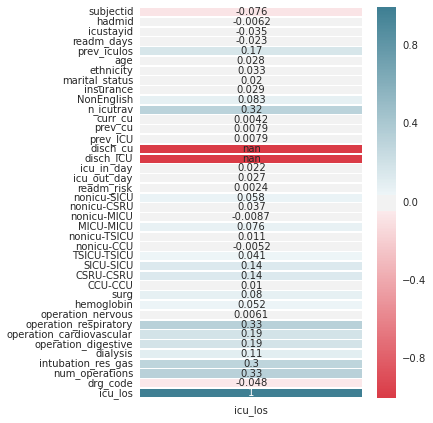

In [173]:
plt.figure(figsize=(5,7))
data_pcorr = df_icustay_f.corr() # Pearson's correlation
cmap = sns.diverging_palette(10, 220, as_cmap=True) # heatmap colorm map
sns.heatmap(data_pcorr[['icu_los']], annot=True, cmap = cmap, 
            linewidths=0.3)
plt.show()

# Predictive Modeling
Array of Random Forest sub-models tailored to disease groups.

In [50]:
am_debugging = True
if am_debugging:
    np.random.seed(2)
else:
    np.random.seed()

In [51]:
def rf_gridsearch(X_train, X_test, y_train):
    # Parameter Grid - dictionary of parameters (map parameter names to values to be searched)
    param_grid = [
        {'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
         'criterion': ['mse', 'mae']}
    ]

    rfr = RandomForestRegressor(random_state=2
#                                 , n_jobs=-1
                               ) # AWS unable to do parallel computing

    # Grid search to find "best" random forest classifier -- Hyperparameters Optimization
    clf = grid_search.GridSearchCV(rfr, param_grid)  # classifier + optimal parameters
    clf = clf.fit(X_train, y_train)  # fitted classifier -- Training Set
    best_est = clf.best_estimator_
    clf_pred = best_est.predict(X_test)  # apply classifier on test set for label predictions
    params = clf.best_params_  # optimal parameters
    score = clf.best_score_  # best grid score
    imp = best_est.feature_importances_
    return (best_est, clf_pred, params, score, imp)

## Heart (Cardiovascular) Diseases
### Cardiovascular Disease - Surgical

In [52]:
q_cardio = procedure = """
SELECT drg_code
FROM drgcodes
WHERE LOWER(description) LIKE '%with acute myocardial infarction%' OR
LOWER(description) LIKE '%heart failure%' OR
LOWER(description) LIKE '%coronary bypass%' OR
LOWER(description) LIKE '%cardiac%' OR
LOWER(description) LIKE '%heart transplant%' OR
LOWER(description) LIKE '%cardiothoracic%' OR
LOWER(description) LIKE '%percutaneous cardiovascular procedure%'
GROUP BY drg_code;
"""

cdv = exec_query(q_cardio)
cdv = np.array(cdv).flatten().astype(int)

df_icustay_cdv = df_icustay_f[df_icustay_f['drg_code'].isin(cdv)]
df_icustay_cdv.shape

(2579, 40)

In [53]:
df_icustay_cdv['icu_los'].describe()

count    2579.000000
mean        3.802191
std         4.340727
min         0.001400
25%         1.311000
50%         2.380700
75%         4.344800
max        58.798700
Name: icu_los, dtype: float64

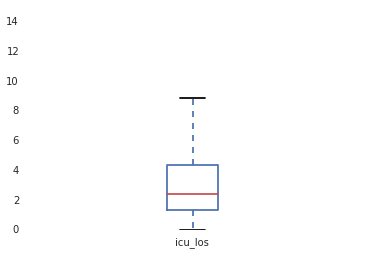

In [54]:
df_icustay_cdv['icu_los'].plot(kind='box', ylim=[0, 15])

#### Partition: Training & Testing Sets

In [55]:
def data_partition(data, train_thres=0.75):
    """
    Helper function identifying indices for each record to be a part of the
    training set. The quantity of a given subject's set of records is determined
    by the training threshold.
    
    :param data: pandas DataFrame
    :param train_thres: float indicating threshold
    :return: list of training indices
    """
    if train_thres > 0.83:
        return "This helper function is not appropriate for training threshold > 83%."
    
    idx_lst = []
    subj_count = dict(Counter(data.subjectid))
    sid_lst = list(data.subjectid.value_counts().index.sort_values(ascending=True))
    for sid in sid_lst:
        idx_min = data['subjectid'][data.subjectid == sid].idxmin() # find first index for each subject
        if subj_count[sid] > 2:
            end_idx = idx_min + int(np.round(subj_count[sid] * train_thres))
            idx_lst += range(idx_min, end_idx) # list of index for each subject
        else:
            idx_lst += [idx_min]
    return idx_lst

In [56]:
data = df_icustay_cdv.copy()

train_idx = data_partition(data, 0.80) # training set indices
train_data = data.ix[train_idx]
test_idx = data.index[data.index.isin(train_idx)==False] # test set indices
test_data = data.ix[test_idx]

train_data.shape, test_data.shape

((1842, 40), (786, 40))

#### Drop Arbitrary Identifiers
Drop `subjectid`, `hadmid`, and `icustayid` that serve only for the purpose of identification.

In [57]:
train_data.drop(['subjectid','hadmid', 'icustayid'], axis=1, inplace=True)
test_data.drop(['subjectid','hadmid', 'icustayid'], axis=1, inplace=True)

train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

In [58]:
X_train = train_data.iloc[:, :-1]
X_test = test_data.iloc[:, :-1]
y_train = np.array(train_data.iloc[:, -1])
y_test = np.array(test_data.iloc[:, -1])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1793, 36), (786, 36), (1793,), (786,))

#### Normalization

In [59]:
scaler = StandardScaler().fit(X_train) # scaler object fitted to training set

# Transform
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

scaled_X_train.shape, scaled_X_test.shape, y_train.shape, y_test.shape

((1793, 36), (786, 36), (1793,), (786,))

### Model: Random Forest

#### Criterion
  1. **mse**: mean squared error
  2. **mae**: mean absolute error

In [60]:
rf_model, rf_pred, rf_p, rf_score, rf_imp = rf_gridsearch(scaled_X_train, scaled_X_test, y_train)
print "Best Parameters: ", rf_p
print "Best Grid Search Score: ", rf_score
print "Best Estimator: ", rf_model

Best Parameters:  {'n_estimators': 10, 'criterion': 'mse'}
Best Grid Search Score:  -0.0187191624124
Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=2,
           verbose=0, warm_start=False)


### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [61]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test, rf_pred))

RMSE = 2.432 days


In [62]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,58.80]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [63]:
print " MAE = %.3f" % mean_absolute_error(y_test, rf_pred)

 MAE = 1.334


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [64]:
print "r2 = %.3f" % r2_score(y_test, rf_pred)

r2 = 0.710


### Prediction Comparison

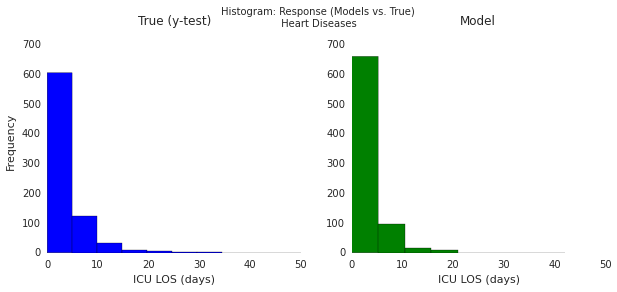

In [171]:
x_lim = [0,50]
y_lim = [0,750]

plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.hist(np.round(y_test), bins=12, color='b')
plt.title("True (y-test)")
plt.xlabel('ICU LOS (days)')
plt.ylabel('Frequency')
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(rf_pred), bins=8, color='g')
plt.title("Model")
plt.xlabel('ICU LOS (days)')
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.suptitle('Histogram: Response (Models vs. True) \n Heart Diseases')

plt.show()

### Error Visualization: MAE

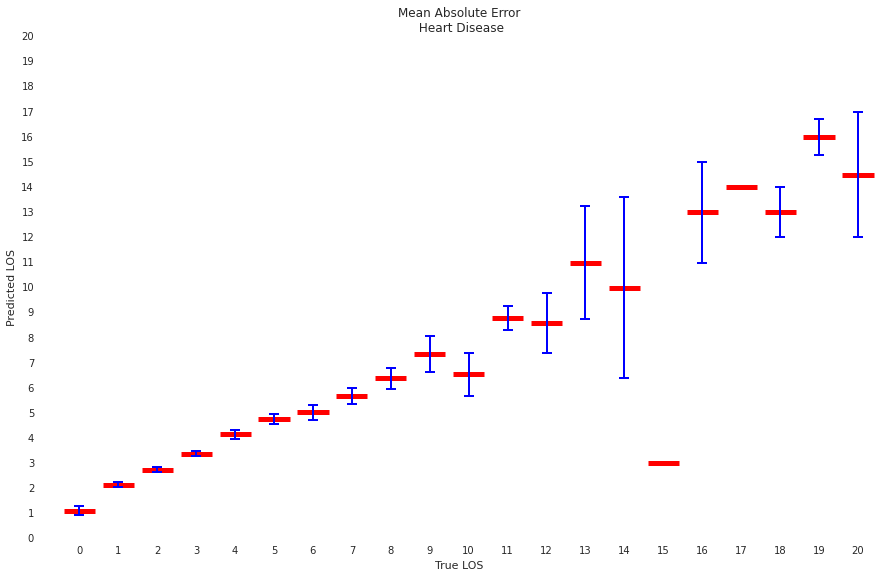

In [198]:
df_rfpred = pd.Series(rf_pred, name="pred").round()
df_true = pd.Series(y_test, name = "true").round()

df_rfresults = pd.concat([df_true, df_rfpred], axis=1)
rf_residual = pd.Series(df_rfresults['true'].sub(df_rfresults['pred'], axis=0).abs(), name='resid')
df_rfresults = pd.concat([df_rfresults, rf_residual], axis=1)

rf_errort = df_rfresults[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

# Error Plot
plt.subplots(1,1,figsize=(15,9))

# # error bar - range
# plt.bar(left=[i for i in rf_errort.index.tolist()], 
#         height=rf_errort[['pred']].values[:,3] - rf_errort[['pred']].values[:,4], # range (max-min)
#         width=0.8, 
#         bottom=rf_errort[['pred']].values[:,4], # min
#         color='b', alpha=0.3, align='center', orientation='vertical') 


plt.bar(left=[i for i in rf_errort.index.tolist()], 
        height=[0]*len(rf_errort), 
        width=0.8, 
        bottom=rf_errort[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=rf_errort[['pred']].values[:,2] / rf_errort[['pred']].values[:,-1] ** 0.5,  # error: standard deviation
        orientation='vertical',
        error_kw=dict(ecolor='blue', lw=2, capsize=5, capthick=2))
    
plt.xlabel('True LOS')
plt.xticks(rf_errort.index)
plt.yticks(rf_errort.index)
plt.ylabel('Predicted LOS')
plt.xlim([-1,20.5])
plt.ylim([0,20])
plt.title('Mean Absolute Error \n Heart Disease')

# plt.gca().set_axis_bgcolor('white')

plt.show()

## Respiratory Systems
### Respiratory Systems - Surgical

In [66]:
q_resp_surg = """
SELECT drg_code, description
FROM drgcodes
WHERE LOWER(description) LIKE ANY 
        (array['%major chest%', '%pulmonary%', '%respiratory%', '%pneumonia%', '%asthma%'])
    AND LOWER(description) LIKE '%proc%'
GROUP BY drg_code, description;
"""
resp_surg = exec_query(q_resp_surg)
resp_surg_df = pd.DataFrame(resp_surg, columns=['code', 'desc'])
resp_surg_lst = resp_surg_df['code'].values.astype(int)

df_icustay_resp_surg = df_icustay_f[df_icustay_f['drg_code'].isin(resp_surg_lst)]
df_icustay_resp_surg.shape

(261, 40)

In [67]:
df_icustay_resp_surg['icu_los'].describe()

count    261.000000
mean       5.478103
std        7.544074
min        0.077400
25%        1.855500
50%        3.141200
75%        5.618800
max       47.531600
Name: icu_los, dtype: float64

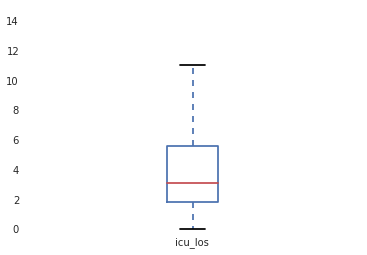

In [68]:
df_icustay_resp_surg['icu_los'].plot(kind='box', ylim=[0, 15])

#### Partition: Training & Testing Sets

In [69]:
data1 = df_icustay_resp_surg.copy()

train_idx1 = data_partition(data1, 0.80)
train_data1 = data1.ix[train_idx1]
test_idx1 = data1.index[data1.index.isin(train_idx1)==False]
test_data1 = data1.ix[test_idx1]

train_data1.shape, test_data1.shape

((180, 40), (86, 40))

#### Drop Arbitrary Identifiers
Drop `subjectid`, `hadmid`, and `icustayid` that serve only for the purpose of identification.

In [70]:
train_data1.drop(['subjectid','hadmid', 'icustayid'], axis=1, inplace=True)
test_data1.drop(['subjectid','hadmid', 'icustayid'], axis=1, inplace=True)

train_data1.dropna(inplace=True)
test_data1.dropna(inplace=True)

In [71]:
X_train1 = train_data1.iloc[:, :-1]
X_test1 = test_data1.iloc[:, :-1]
y_train1 = np.array(train_data1.iloc[:, -1])
y_test1 = np.array(test_data1.iloc[:, -1])
X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape

((175, 36), (86, 36), (175,), (86,))

#### Normalization

In [72]:
scaler1 = StandardScaler().fit(X_train1) # scaler object fitted to training set

# Transform
scaled_X_train1 = scaler1.transform(X_train1)
scaled_X_test1 = scaler1.transform(X_test1)

scaled_X_train1.shape, scaled_X_test1.shape, y_train1.shape, y_test1.shape

((175, 36), (86, 36), (175,), (86,))

### Model: Random Forest

#### Criterion
  1. **mse**: mean squared error
  2. **mae**: mean absolute error

In [73]:
rf_model1, rf_pred1, rf_p1, rf_score1, rf_imp1 = rf_gridsearch(scaled_X_train1, scaled_X_test1, y_train1)
print "Best Parameters: ", rf_p1
print "Best Grid Search Score: ", rf_score1
print "Best Estimator: ", rf_model1

Best Parameters:  {'n_estimators': 10, 'criterion': 'mse'}
Best Grid Search Score:  -0.592711108748
Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=2,
           verbose=0, warm_start=False)


### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [74]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test1, rf_pred1))

RMSE = 2.586 days


In [75]:
print "[%.2f,%.2f]" % (y_test1.min(), y_test1.max())

[0.08,47.53]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [76]:
print " MAE = %.3f" % mean_absolute_error(y_test1, rf_pred1)

 MAE = 1.696


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [77]:
print "r2 = %.3f" % r2_score(y_test1, rf_pred1)

r2 = 0.874


### Respiratory System - Medical

In [78]:
q_resp_med = """
SELECT drg_code, description
FROM drgcodes
WHERE LOWER(description) LIKE ANY 
        (array['%major chest trauma%', '%pulmonary%', '%respiratory%', '%pneumonia%', '%asthma%', '%pleural effusion%',
        '%lung disease%', '%interstitial%', '%bronhitis%'])
    AND LOWER(description) NOT LIKE '%proc%'
GROUP BY drg_code, description;
"""
resp_med = exec_query(q_resp_med)
resp_med_df = pd.DataFrame(resp_med, columns=['code', 'desc'])
resp_med_lst = resp_med_df['code'].values.astype(int)

df_icustay_resp_med = df_icustay_f[df_icustay_f['drg_code'].isin(resp_med_lst)]
df_icustay_resp_med.shape

(1780, 40)

In [79]:
df_icustay_resp_med['icu_los'].describe()

count    1780.000000
mean        4.473982
std         5.745641
min         0.003600
25%         1.384100
50%         2.727250
75%         5.224700
max        97.489700
Name: icu_los, dtype: float64

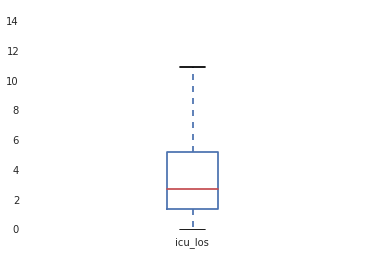

In [80]:
df_icustay_resp_med['icu_los'].plot(kind='box', ylim=[0, 15])

#### Partition: Training & Testing Sets

In [81]:
data3 = df_icustay_resp_med.copy()

train_idx3 = data_partition(data3, 0.80)
train_data3 = data3.ix[train_idx3]
test_idx3 = data3.index[data3.index.isin(train_idx3)==False]
test_data3 = data3.ix[test_idx3]

train_data3.shape, test_data3.shape

((1289, 40), (519, 40))

#### Drop Arbitrary Identifiers
Drop `subjectid`, `hadmid`, and `icustayid` that serve only for the purpose of identification.

In [82]:
train_data3.drop(['subjectid','hadmid', 'icustayid'], axis=1, inplace=True)
test_data3.drop(['subjectid','hadmid', 'icustayid'], axis=1, inplace=True)

train_data3.dropna(inplace=True)
test_data3.dropna(inplace=True)

In [83]:
X_train3 = train_data3.iloc[:, :-1]
X_test3 = test_data3.iloc[:, :-1]
y_train3 = np.array(train_data3.iloc[:, -1])
y_test3 = np.array(test_data3.iloc[:, -1])
X_train3.shape, X_test3.shape, y_train3.shape, y_test3.shape

((1261, 36), (519, 36), (1261,), (519,))

#### Normalization

In [84]:
scaler3 = StandardScaler().fit(X_train3) # scaler object fitted to training set

# Transform
scaled_X_train3 = scaler3.transform(X_train3)
scaled_X_test3 = scaler3.transform(X_test3)

scaled_X_train3.shape, scaled_X_test3.shape, y_train3.shape, y_test3.shape

((1261, 36), (519, 36), (1261,), (519,))

### Model: Random Forest

#### Criterion
  1. **mse**: mean squared error
  2. **mae**: mean absolute error

In [85]:
rf_model3, rf_pred3, rf_p3, rf_score3, rf_imp3 = rf_gridsearch(scaled_X_train3, scaled_X_test3, y_train3)
print "Best Parameters: ", rf_p3
print "Best Grid Search Score: ", rf_score3
print "Best Estimator: ", rf_model3

Best Parameters:  {'n_estimators': 10, 'criterion': 'mae'}
Best Grid Search Score:  0.0711288601286
Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=2,
           verbose=0, warm_start=False)


### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [81]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test3, rf_pred3))

RMSE = 5.086 days


In [82]:
print "[%.2f,%.2f]" % (y_test3.min(), y_test3.max())

[0.00,97.49]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [83]:
print " MAE = %.3f" % mean_absolute_error(y_test3, rf_pred3)

 MAE = 1.964


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [88]:
print "r2 = %.3f" % r2_score(y_test3, rf_pred3)

r2 = 0.468


### Prediction Comparison

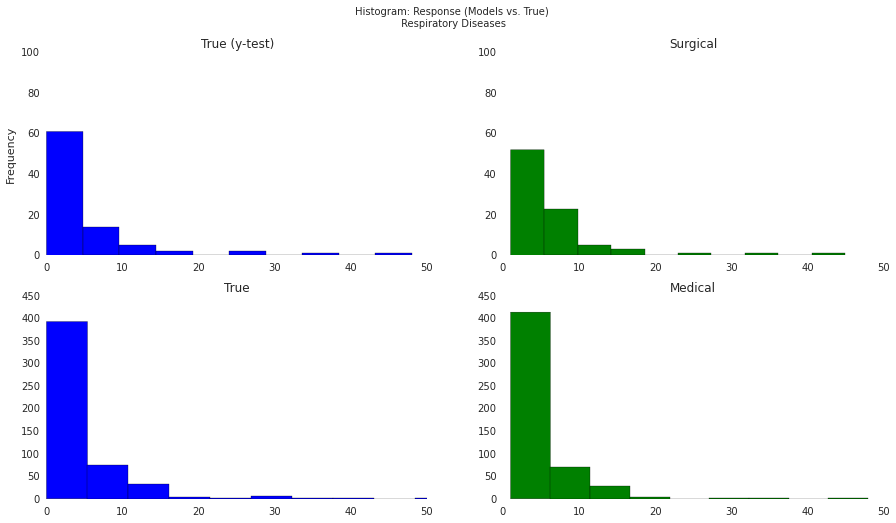

In [98]:
x_lim = [0,50]
y_lim = [0,450]

plt.figure(figsize=(15, 8))
plt.subplot(2,2,1)
plt.hist(np.round(y_test1), bins=10, color='b')
plt.title("True (y-test)")
plt.ylabel('Frequency')
plt.xlim(x_lim)
plt.ylim([0,100])
plt.legend(loc='upper right')

plt.subplot(2,2,2)
plt.hist(np.round(rf_pred1), bins=10, color='g')
plt.title("Surgical")
plt.xlim(x_lim)
plt.ylim([0,100])
plt.legend(loc='upper right')

plt.subplot(2,2,3)
plt.hist(np.round(y_test3), bins=18, color='b')
plt.title("True")
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.subplot(2,2,4)
plt.hist(np.round(rf_pred3), bins=9, color='g')
plt.title("Medical")
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.legend(loc='upper right')

plt.suptitle('Histogram: Response (Models vs. True) \n Respiratory Diseases')

plt.show()

### Error Visualization: MAE

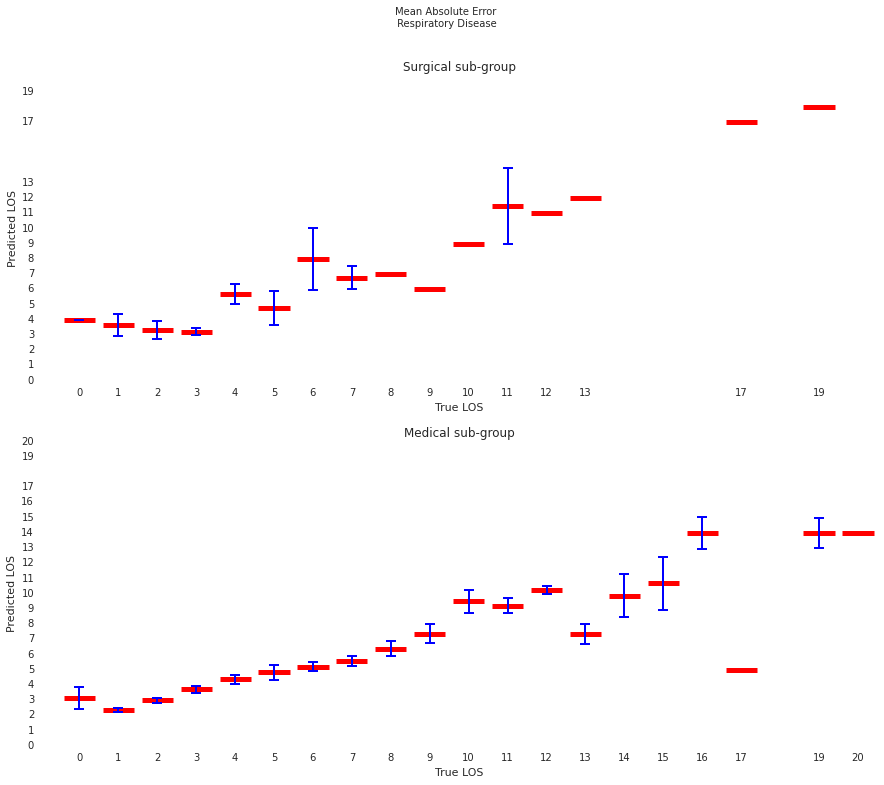

In [222]:
# Surgical
df_rfpred1 = pd.Series(rf_pred1, name="pred").round()
df_true1 = pd.Series(y_test1, name = "true").round()

df_rfresults1 = pd.concat([df_true1, df_rfpred1], axis=1)
rf_residual1 = pd.Series(df_rfresults1['true'].sub(df_rfresults1['pred'], axis=0).abs(), name='resid')
df_rfresults1 = pd.concat([df_rfresults1, rf_residual1], axis=1)

rf_errort1 = df_rfresults1[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

# Medical
df_rfpred3 = pd.Series(rf_pred3, name="pred").round()
df_true3 = pd.Series(y_test3, name = "true").round()

df_rfresults3 = pd.concat([df_true3, df_rfpred3], axis=1)
rf_residual3 = pd.Series(df_rfresults3['true'].sub(df_rfresults3['pred'], axis=0).abs(), name='resid')
df_rfresults3 = pd.concat([df_rfresults3, rf_residual3], axis=1)

rf_errort3 = df_rfresults3[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

# Error Plot
plt.figure(figsize=(15,12))
plt.subplot(2,1,1)

plt.bar(left=[i for i in rf_errort1.index.tolist()], 
        height=[0]*len(rf_errort1), 
        width=0.8, 
        bottom=rf_errort1[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=rf_errort1[['pred']].values[:,2] / rf_errort1[['pred']].values[:,-1] ** 0.5,  # error: standard deviation
        orientation='vertical',
        error_kw=dict(ecolor='blue', lw=2, capsize=5, capthick=2))
    
plt.xlabel('True LOS')
plt.xticks(rf_errort1.index)
plt.yticks(rf_errort1.index)
plt.ylabel('Predicted LOS')
plt.xlim([-1,20.5])
plt.ylim([0,20])
plt.title('Surgical sub-group')

plt.subplot(2,1,2)
plt.bar(left=[i for i in rf_errort3.index.tolist()], 
        height=[0]*len(rf_errort3), 
        width=0.8, 
        bottom=rf_errort3[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=rf_errort3[['pred']].values[:,2] / rf_errort3[['pred']].values[:,-1] ** 0.5,  # error: standard deviation
        orientation='vertical',
        error_kw=dict(ecolor='blue', lw=2, capsize=5, capthick=2))
    
plt.xlabel('True LOS')
plt.xticks(rf_errort3.index)
plt.yticks(rf_errort3.index)
plt.ylabel('Predicted LOS')
plt.xlim([-1,20.5])
plt.ylim([0,20])
plt.title('Medical sub-group')

plt.suptitle('Mean Absolute Error \n Respiratory Disease')

plt.show()


## Musculoskeletal Systems
### Musculoskeletal Systems - Surgical

In [206]:
q_muscoskeletal_surg = """
SELECT drg_code, description
FROM drgcodes
WHERE LOWER(description) LIKE ANY 
        (array['%spinal fusion%', '%skn grft%', '%knee replacement%', '%hip replacement%', '%joint replacement%'
        '%amputation for musculoskeletal%', '%biopsies of musculo%','%femur procedures%','%limb reatacchment%', 
        '%knee proc%', '%humer proc%', '%local excision%', '%soft tissue proc%', '%foot proc%', '%joint proc%', 
        '%arthroscopy%', 'forearm proc%', '%pathological fracture%'])
GROUP BY drg_code, description;
"""
muscoskeletal_surg = exec_query(q_muscoskeletal_surg)
muscoskeletal_surg_df = pd.DataFrame(muscoskeletal_surg, columns=['code', 'desc'])
muscoskeletal_surg_lst = muscoskeletal_surg_df['code'].values.astype(int)

df_icustay_muscoskeletal_surg = df_icustay_f[df_icustay_f['drg_code'].isin(muscoskeletal_surg_lst)]
df_icustay_muscoskeletal_surg.shape

(578, 40)

In [207]:
df_icustay_muscoskeletal_surg['icu_los'].describe()

count    578.000000
mean       4.687609
std        7.668103
min        0.004300
25%        1.416375
50%        2.412350
75%        4.575450
max       84.040900
Name: icu_los, dtype: float64

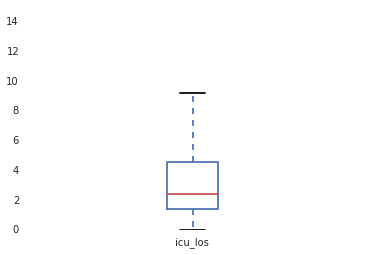

In [208]:
df_icustay_muscoskeletal_surg['icu_los'].plot(kind='box', ylim=[0, 15])

#### Partition: Training & Testing Sets

In [209]:
data2 = df_icustay_muscoskeletal_surg.copy()

train_idx2 = data_partition(data2, 0.80)
train_data2 = data2.ix[train_idx2]
test_idx2 = data2.index[data2.index.isin(train_idx2)==False]
test_data2 = data2.ix[test_idx2]

train_data2.shape, test_data2.shape

((450, 40), (141, 40))

#### Drop Arbitrary Identifiers
Drop `subjectid`, `hadmid`, and `icustayid` that serve only for the purpose of identification.

In [210]:
train_data2.drop(['subjectid','hadmid', 'icustayid'], axis=1, inplace=True)
test_data2.drop(['subjectid','hadmid', 'icustayid'], axis=1, inplace=True)

train_data2.dropna(inplace=True)
test_data2.dropna(inplace=True)

In [211]:
X_train2 = train_data2.iloc[:, :-1]
X_test2 = test_data2.iloc[:, :-1]
y_train2 = np.array(train_data2.iloc[:, -1])
y_test2 = np.array(test_data2.iloc[:, -1])
X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape

((437, 36), (141, 36), (437,), (141,))

#### Normalization

In [212]:
scaler2 = StandardScaler().fit(X_train2) # scaler object fitted to training set

# Transform
scaled_X_train2 = scaler2.transform(X_train2)
scaled_X_test2 = scaler2.transform(X_test2)

scaled_X_train2.shape, scaled_X_test2.shape, y_train2.shape, y_test2.shape

((437, 36), (141, 36), (437,), (141,))

### Model: Random Forest

#### Criterion
  1. **mse**: mean squared error
  2. **mae**: mean absolute error

In [213]:
rf_model2, rf_pred2, rf_p2, rf_score2, rf_imp2 = rf_gridsearch(scaled_X_train2, scaled_X_test2, y_train2)
print "Best Parameters: ", rf_p2
print "Best Grid Search Score: ", rf_score2
print "Best Estimator: ", rf_model2

Best Parameters:  {'n_estimators': 9, 'criterion': 'mse'}
Best Grid Search Score:  -0.466636925662
Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=9, n_jobs=1, oob_score=False, random_state=2,
           verbose=0, warm_start=False)


### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [93]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test2, rf_pred2))

RMSE = 5.728 days


In [94]:
print "[%.2f,%.2f]" % (y_test2.min(), y_test2.max())

[0.00,36.12]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [95]:
print " MAE = %.3f" % mean_absolute_error(y_test2, rf_pred2)

 MAE = 3.203


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [96]:
print "r2 = %.3f" % r2_score(y_test2, rf_pred2)

r2 = -0.115


### Musculoskeletal Systems - Medical

In [214]:
q_muscoskeletal_med = """
SELECT drg_code, description
FROM drgcodes
WHERE LOWER(description) LIKE ANY 
        (array['%fractures%', '%sprains%', '%dislocation%', '%osteomyelitis%', '%connective tissue disorders%'
        '%arthritis%', '%back problem%','%bone disease%','%arthropathies%', 
        '%tendonitis%', '%musculotskeletal system%', '%connective tissue diag'])
GROUP BY drg_code, description;
"""
muscoskeletal_med = exec_query(q_muscoskeletal_med)
muscoskeletal_med_df = pd.DataFrame(muscoskeletal_med, columns=['code', 'desc'])
muscoskeletal_med_lst = muscoskeletal_med_df['code'].values.astype(int)

df_icustay_muscoskeletal_med = df_icustay_f[df_icustay_f['drg_code'].isin(muscoskeletal_med_lst)]
df_icustay_muscoskeletal_med.shape

(394, 40)

In [215]:
df_icustay_muscoskeletal_med['icu_los'].describe()

count    394.000000
mean       4.449780
std        5.937692
min        0.058600
25%        1.284100
50%        2.462100
75%        5.085750
max       49.120000
Name: icu_los, dtype: float64

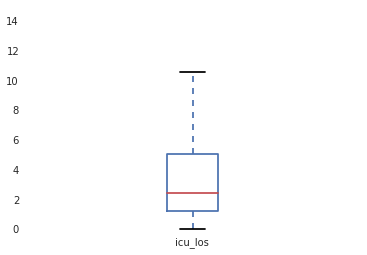

In [216]:
df_icustay_muscoskeletal_med['icu_los'].plot(kind='box', ylim=[0, 15])

#### Partition: Training & Testing Sets

In [217]:
data4 = df_icustay_muscoskeletal_med.copy()

train_idx4 = data_partition(data4, 0.80)
train_data4 = data4.ix[train_idx4]
test_idx4 = data4.index[data4.index.isin(train_idx4)==False]
test_data4 = data4.ix[test_idx4]

train_data4.shape, test_data4.shape

((309, 40), (94, 40))

#### Drop Arbitrary Identifiers
Drop `subjectid`, `hadmid`, and `icustayid` that serve only for the purpose of identification.

In [218]:
train_data4.drop(['subjectid','hadmid', 'icustayid'], axis=1, inplace=True)
test_data4.drop(['subjectid','hadmid', 'icustayid'], axis=1, inplace=True)

train_data4.dropna(inplace=True)
test_data4.dropna(inplace=True)

In [219]:
X_train4 = train_data4.iloc[:, :-1]
X_test4 = test_data4.iloc[:, :-1]
y_train4 = np.array(train_data4.iloc[:, -1])
y_test4 = np.array(test_data4.iloc[:, -1])
X_train4.shape, X_test4.shape, y_train4.shape, y_test4.shape

((300, 36), (94, 36), (300,), (94,))

#### Normalization

In [220]:
scaler4 = StandardScaler().fit(X_train4) # scaler object fitted to training set

# Transform
scaled_X_train4 = scaler4.transform(X_train4)
scaled_X_test4 = scaler4.transform(X_test4)

scaled_X_train4.shape, scaled_X_test4.shape, y_train4.shape, y_test4.shape

((300, 36), (94, 36), (300,), (94,))

### Model: Random Forest

#### Criterion
  1. **mse**: mean squared error
  2. **mae**: mean absolute error

In [221]:
rf_model4, rf_pred4, rf_p4, rf_score4, rf_imp4 = rf_gridsearch(scaled_X_train4, scaled_X_test4, y_train4)
print "Best Parameters: ", rf_p4
print "Best Grid Search Score: ", rf_score4
print "Best Estimator: ", rf_model4

Best Parameters:  {'n_estimators': 9, 'criterion': 'mse'}
Best Grid Search Score:  -0.00779642256267
Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=9, n_jobs=1, oob_score=False, random_state=2,
           verbose=0, warm_start=False)


### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [105]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test4, rf_pred4))

RMSE = 4.577 days


In [106]:
print "[%.2f,%.2f]" % (y_test4.min(), y_test4.max())

[0.20,36.12]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [107]:
print " MAE = %.3f" % mean_absolute_error(y_test4, rf_pred4)

 MAE = 2.509


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [108]:
print "r2 = %.3f" % r2_score(y_test4, rf_pred4)

r2 = 0.234


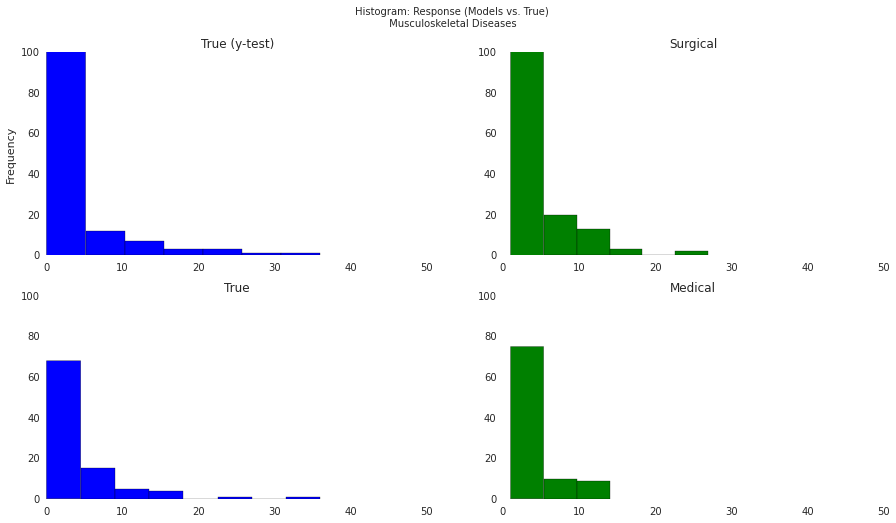

In [109]:
x_lim = [0,50]
y_lim = [0,450]

plt.figure(figsize=(15, 8))
plt.subplot(2,2,1)
plt.hist(np.round(y_test2), bins=7, color='b')
plt.title("True (y-test)")
plt.ylabel('Frequency')
plt.xlim(x_lim)
plt.ylim([0,100])
plt.legend(loc='upper right')

plt.subplot(2,2,2)
plt.hist(np.round(rf_pred2), bins=6, color='g')
plt.title("Surgical")
plt.xlim(x_lim)
plt.ylim([0,100])
plt.legend(loc='upper right')

plt.subplot(2,2,3)
plt.hist(np.round(y_test4), bins=8, color='b')
plt.title("True")
plt.xlim(x_lim)
plt.ylim([0,100])
plt.legend(loc='upper right')

plt.subplot(2,2,4)
plt.hist(np.round(rf_pred4), bins=3, color='g')
plt.title("Medical")
plt.xlim(x_lim)
plt.ylim([0,100])
plt.legend(loc='upper right')

plt.suptitle('Histogram: Response (Models vs. True) \n Musculoskeletal Diseases')

plt.show()

### Error Visualization: MAE

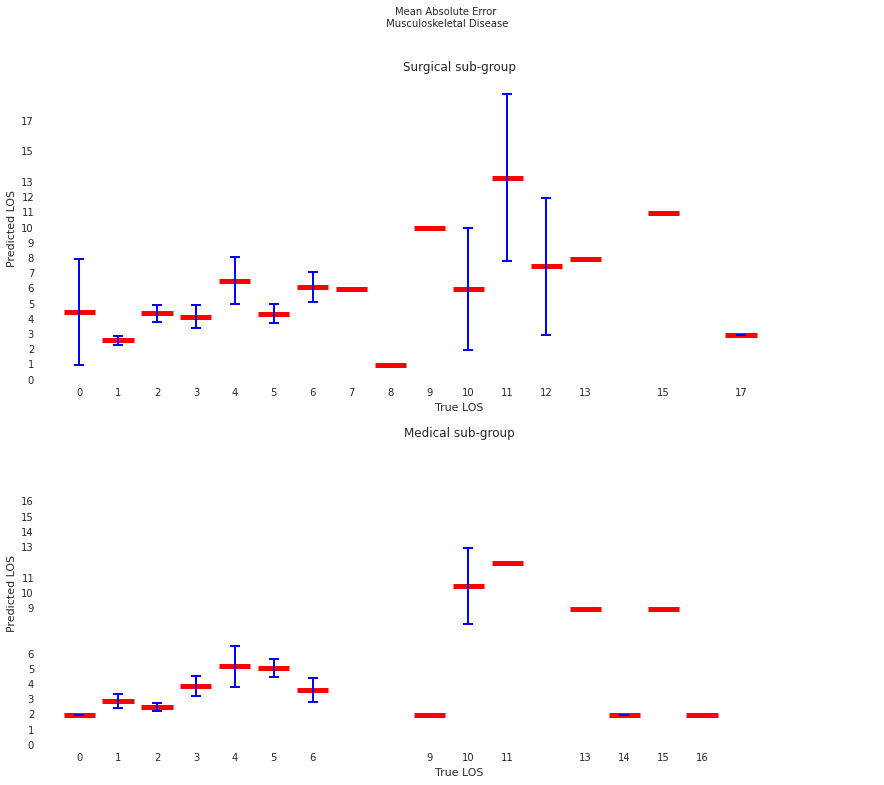

In [224]:
# Surgical
df_rfpred2 = pd.Series(rf_pred2, name="pred").round()
df_true2 = pd.Series(y_test2, name = "true").round()

df_rfresults2 = pd.concat([df_true2, df_rfpred2], axis=1)
rf_residual2 = pd.Series(df_rfresults2['true'].sub(df_rfresults1['pred'], axis=0).abs(), name='resid')
df_rfresults2 = pd.concat([df_rfresults2, rf_residual2], axis=1)

rf_errort2 = df_rfresults2[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

# Medical
df_rfpred4 = pd.Series(rf_pred4, name="pred").round()
df_true4 = pd.Series(y_test4, name = "true").round()

df_rfresults4 = pd.concat([df_true4, df_rfpred4], axis=1)
rf_residual4 = pd.Series(df_rfresults4['true'].sub(df_rfresults4['pred'], axis=0).abs(), name='resid')
df_rfresults4 = pd.concat([df_rfresults4, rf_residual4], axis=1)

rf_errort4 = df_rfresults4[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

# Error Plot
plt.figure(figsize=(15,12))
plt.subplot(2,1,1)

plt.bar(left=[i for i in rf_errort2.index.tolist()], 
        height=[0]*len(rf_errort2), 
        width=0.8, 
        bottom=rf_errort2[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=rf_errort2[['pred']].values[:,2] / rf_errort2[['pred']].values[:,-1] ** 0.5,  # error: standard deviation
        orientation='vertical',
        error_kw=dict(ecolor='blue', lw=2, capsize=5, capthick=2))
    
plt.xlabel('True LOS')
plt.xticks(rf_errort2.index)
plt.yticks(rf_errort2.index)
plt.ylabel('Predicted LOS')
plt.xlim([-1,20.5])
plt.ylim([0,20])
plt.title('Surgical sub-group')

plt.subplot(2,1,2)
plt.bar(left=[i for i in rf_errort4.index.tolist()], 
        height=[0]*len(rf_errort4), 
        width=0.8, 
        bottom=rf_errort4[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=rf_errort4[['pred']].values[:,2] / rf_errort4[['pred']].values[:,-1] ** 0.5,  # error: standard deviation
        orientation='vertical',
        error_kw=dict(ecolor='blue', lw=2, capsize=5, capthick=2))
    
plt.xlabel('True LOS')
plt.xticks(rf_errort4.index)
plt.yticks(rf_errort4.index)
plt.ylabel('Predicted LOS')
plt.xlim([-1,20.5])
plt.ylim([0,20])
plt.title('Medical sub-group')

plt.suptitle('Mean Absolute Error \n Musculoskeletal Disease')

plt.show()

## Nervous System Diseases

### Nervous System - Surgical

In [104]:
q_nerv_surg = """
SELECT drg_code, description
FROM drgcodes
WHERE LOWER(description) LIKE ANY 
        (array['%nervous%', '%encephalopathy%', '%coma%','%stupor%', 
        '%cerebrovascular disorders%','%nerve disorders%','%meningitis%', 
        '%cranial%', '%ventricular shunt%'])
    AND LOWER(description) LIKE '%proc%'
GROUP BY drg_code, description;
"""
nerv_surg = exec_query(q_nerv_surg)
nerv_surg_lst = pd.DataFrame(nerv_surg, columns=['code', 'desc'])['code']
nerv_surg_lst = nerv_surg_lst.values.astype(int)

In [105]:
df_icustay_nerv_surg = df_icustay_f[df_icustay_f['drg_code'].isin(nerv_surg_lst)]
df_icustay_nerv_surg.shape

(440, 40)

In [106]:
df_icustay_nerv_surg['icu_los'].describe()

count    440.000000
mean       3.461402
std        3.783283
min        0.003600
25%        1.142700
50%        2.195900
75%        4.124675
max       30.872500
Name: icu_los, dtype: float64

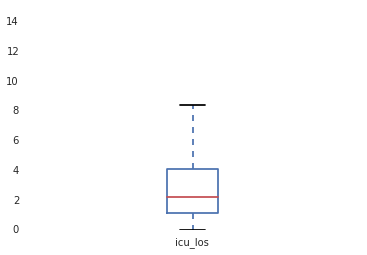

In [107]:
df_icustay_nerv_surg['icu_los'].plot(kind='box', ylim=[0, 15])

#### Partition: Training & Testing Sets

In [108]:
data5 = df_icustay_nerv_surg.copy()

train_idx5 = data_partition(data5, 0.80)
train_data5 = data5.ix[train_idx5]
test_idx5 = data5.index[data5.index.isin(train_idx5)==False]
test_data5 = data5.ix[test_idx5]

train_data5.shape, test_data5.shape

((349, 40), (116, 40))

#### Drop Arbitrary Identifiers
Drop `subjectid`, `hadmid`, and `icustayid` that serve only for the purpose of identification.

In [109]:
train_data5.drop(['subjectid','hadmid', 'icustayid'], axis=1, inplace=True)
test_data5.drop(['subjectid','hadmid', 'icustayid'], axis=1, inplace=True)

train_data5.dropna(inplace=True)
test_data5.dropna(inplace=True)

In [110]:
X_train5 = train_data5.iloc[:, :-1]
X_test5 = test_data5.iloc[:, :-1]
y_train5 = np.array(train_data5.iloc[:, -1])
y_test5 = np.array(test_data5.iloc[:, -1])
X_train5.shape, X_test5.shape, y_train5.shape, y_test5.shape

((324, 36), (116, 36), (324,), (116,))

#### Normalization

In [111]:
scaler5 = StandardScaler().fit(X_train5) # scaler object fitted to training set

# Transform
scaled_X_train5 = scaler5.transform(X_train5)
scaled_X_test5 = scaler5.transform(X_test5)

scaled_X_train5.shape, scaled_X_test5.shape, y_train5.shape, y_test5.shape

((324, 36), (116, 36), (324,), (116,))

## Model: Random Forest

#### Criterion
  1. **mse**: mean squared error
  2. **mae**: mean absolute error

In [112]:
rf_model5, rf_pred5, rf_p5, rf_score5, rf_imp5 = rf_gridsearch(scaled_X_train5, scaled_X_test5, y_train5)
print "Best Parameters: ", rf_p5
print "Best Grid Search Score: ", rf_score5
print "Best Estimator: ", rf_model5

Best Parameters:  {'n_estimators': 8, 'criterion': 'mse'}
Best Grid Search Score:  -0.101979978958
Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=8, n_jobs=1, oob_score=False, random_state=2,
           verbose=0, warm_start=False)


### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [120]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test5, rf_pred5))

RMSE = 4.244 days


In [121]:
print "[%.2f,%.2f]" % (y_test5.min(), y_test5.max())

[0.57,22.78]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [122]:
print " MAE = %.3f" % mean_absolute_error(y_test5, rf_pred5)

 MAE = 2.322


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [123]:
print "r2 = %.3f" % r2_score(y_test5, rf_pred5)

r2 = -0.150


### Nervous System - Medical

In [113]:
q_nerv_med = """
SELECT drg_code, description
FROM drgcodes
WHERE LOWER(description) LIKE ANY 
        (array['%nervous%', '%encephalopathy%', '%coma%','%stupor%', 
        '%cerebrovascular disorders%','%nerve disorders%','%meningitis%', 
        '%multiple sclerosis%', '%degenerative nervous system%', 
        '%cerebellar ataxia%', '%ischemic stroke%', '%cerebral infarction%', 
        '%cranial hemmorrhage%', '%seizure%', '%headache%'])
    AND LOWER(description) NOT LIKE '%proc%'
GROUP BY drg_code, description;
"""
nerv_med = exec_query(q_nerv_med)
nerv_med_df = pd.DataFrame(nerv_med, columns=['code', 'desc'])
nerv_med_lst = nerv_med_df['code'].values.astype(int)

In [114]:
df_icustay_nerv_med = df_icustay_f[df_icustay_f['drg_code'].isin(nerv_med_lst)]
df_icustay_nerv_med.shape

(1669, 40)

In [115]:
df_icustay_nerv_med['icu_los'].describe()

count    1669.000000
mean        6.916665
std        11.383915
min         0.003600
25%         1.400200
50%         2.968800
75%         6.943300
max       173.072500
Name: icu_los, dtype: float64

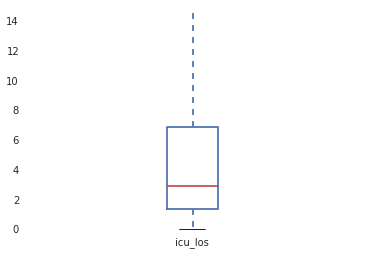

In [116]:
df_icustay_nerv_med['icu_los'].plot(kind='box', ylim=[0, 15])

#### Partition: Training & Testing Sets

In [117]:
data6 = df_icustay_nerv_med.copy()

train_idx6 = data_partition(data6, 0.80)
train_data6 = data6.ix[train_idx6]
test_idx6 = data6.index[data6.index.isin(train_idx6)==False]
test_data6 = data6.ix[test_idx6]

train_data6.shape, test_data6.shape

((1291, 40), (445, 40))

In [118]:
train_data6.drop(['subjectid','hadmid', 'icustayid'], axis=1, inplace=True)
test_data6.drop(['subjectid','hadmid', 'icustayid'], axis=1, inplace=True)

train_data6.dropna(inplace=True)
test_data6.dropna(inplace=True)

X_train6 = train_data6.iloc[:, :-1]
X_test6 = test_data6.iloc[:, :-1]
y_train6 = np.array(train_data6.iloc[:, -1])
y_test6 = np.array(test_data6.iloc[:, -1])
X_train6.shape, X_test6.shape, y_train6.shape, y_test6.shape

((1224, 36), (445, 36), (1224,), (445,))

In [119]:
scaler6 = StandardScaler().fit(X_train6) # scaler object fitted to training set

# Transform
scaled_X_train6 = scaler6.transform(X_train6)
scaled_X_test6 = scaler6.transform(X_test6)

scaled_X_train6.shape, scaled_X_test6.shape, y_train6.shape, y_test6.shape

((1224, 36), (445, 36), (1224,), (445,))

## Model: Random Forest

#### Criterion
  1. **mse**: mean squared error
  2. **mae**: mean absolute error

In [120]:
rf_model6, rf_pred6, rf_p6, rf_score6, rf_imp6 = rf_gridsearch(scaled_X_train6, scaled_X_test6, y_train6)
print "Best Parameters: ", rf_p6
print "Best Grid Search Score: ", rf_score6
print "Best Estimator: ", rf_model6

Best Parameters:  {'n_estimators': 10, 'criterion': 'mae'}
Best Grid Search Score:  0.166515152458
Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=2,
           verbose=0, warm_start=False)


### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [132]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test6, rf_pred6))

RMSE = 7.403 days


In [133]:
print "[%.2f,%.2f]" % (y_test6.min(), y_test6.max())

[0.00,74.31]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [134]:
print " MAE = %.3f" % mean_absolute_error(y_test6, rf_pred6)

 MAE = 4.304


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [135]:
print "r2 = %.3f" % r2_score(y_test6, rf_pred6)

r2 = 0.540


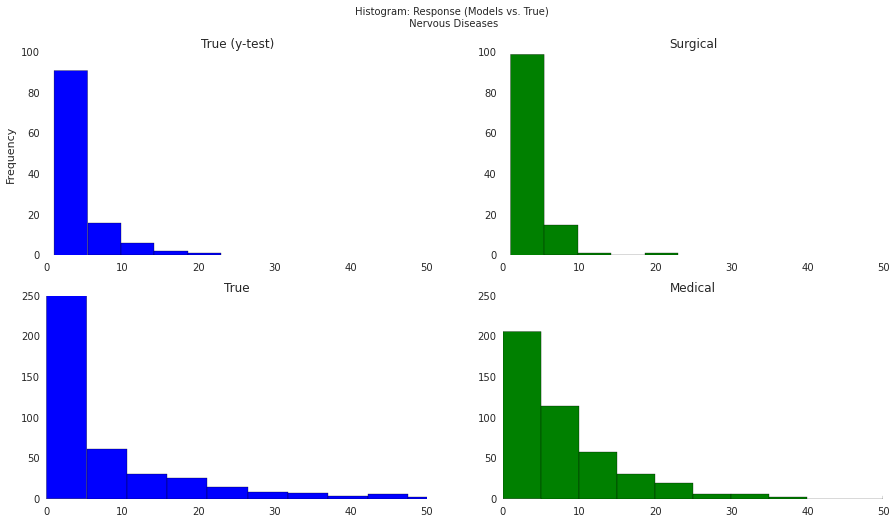

In [136]:
x_lim = [0,50]
y_lim = [0,450]

plt.figure(figsize=(15, 8))
plt.subplot(2,2,1)
plt.hist(np.round(y_test5), bins=5, color='b')
plt.title("True (y-test)")
plt.ylabel('Frequency')
plt.xlim(x_lim)
plt.ylim([0,100])
plt.legend(loc='upper right')

plt.subplot(2,2,2)
plt.hist(np.round(rf_pred5), bins=5, color='g')
plt.title("Surgical")
plt.xlim(x_lim)
plt.ylim([0,100])
plt.legend(loc='upper right')

plt.subplot(2,2,3)
plt.hist(np.round(y_test6), bins=14, color='b')
plt.title("True")
plt.xlim(x_lim)
plt.ylim([0,250])
plt.legend(loc='upper right')

plt.subplot(2,2,4)
plt.hist(np.round(rf_pred6), bins=11, color='g')
plt.title("Medical")
plt.xlim(x_lim)
plt.ylim([0,250])
plt.legend(loc='upper right')

plt.suptitle('Histogram: Response (Models vs. True) \n Nervous Diseases')

plt.show()

### Error Visualization: MAE

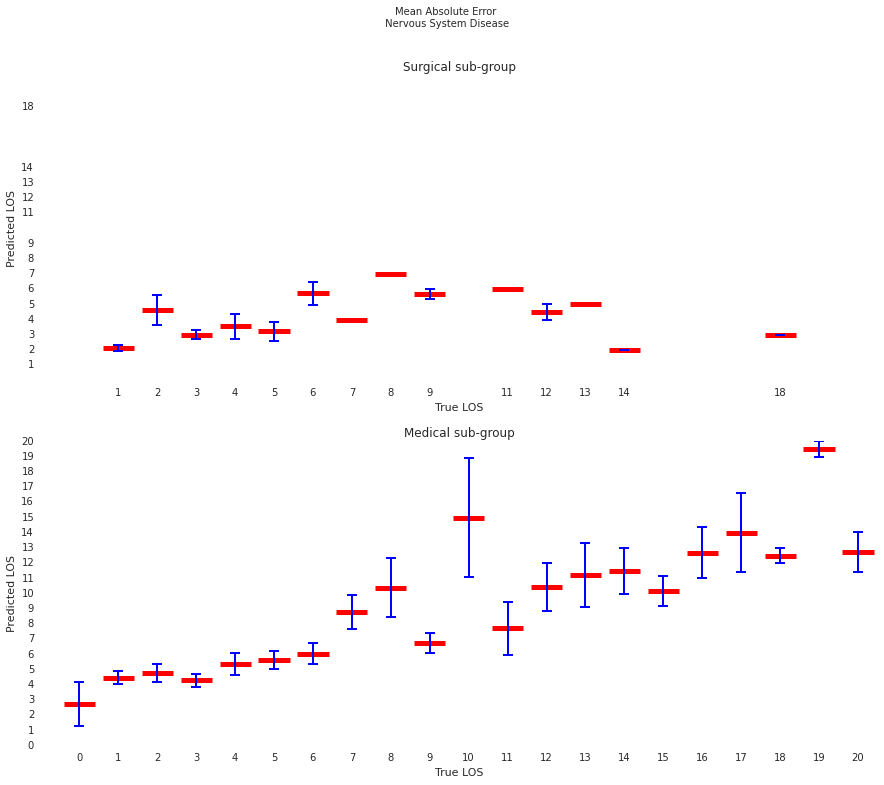

In [227]:
# Surgical
df_rfpred5 = pd.Series(rf_pred5, name="pred").round()
df_true5 = pd.Series(y_test5, name = "true").round()

df_rfresults5 = pd.concat([df_true5, df_rfpred5], axis=1)
rf_residual5 = pd.Series(df_rfresults5['true'].sub(df_rfresults5['pred'], axis=0).abs(), name='resid')
df_rfresults5 = pd.concat([df_rfresults5, rf_residual5], axis=1)

rf_errort5 = df_rfresults5[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

# Medical
df_rfpred6 = pd.Series(rf_pred6, name="pred").round()
df_true6 = pd.Series(y_test6, name = "true").round()

df_rfresults6 = pd.concat([df_true6, df_rfpred6], axis=1)
rf_residual6 = pd.Series(df_rfresults6['true'].sub(df_rfresults6['pred'], axis=0).abs(), name='resid')
df_rfresults6 = pd.concat([df_rfresults6, rf_residual6], axis=1)

rf_errort6 = df_rfresults6[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

# Error Plot
plt.figure(figsize=(15,12))
plt.subplot(2,1,1)

plt.bar(left=[i for i in rf_errort5.index.tolist()], 
        height=[0]*len(rf_errort5), 
        width=0.8, 
        bottom=rf_errort5[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=rf_errort5[['pred']].values[:,2] / rf_errort5[['pred']].values[:,-1] ** 0.5,  # error: standard deviation
        orientation='vertical',
        error_kw=dict(ecolor='blue', lw=2, capsize=5, capthick=2))
    
plt.xlabel('True LOS')
plt.xticks(rf_errort5.index)
plt.yticks(rf_errort5.index)
plt.ylabel('Predicted LOS')
plt.xlim([-1,20.5])
plt.ylim([0,20])
plt.title('Surgical sub-group')

plt.subplot(2,1,2)
plt.bar(left=[i for i in rf_errort6.index.tolist()], 
        height=[0]*len(rf_errort6), 
        width=0.8, 
        bottom=rf_errort6[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=rf_errort6[['pred']].values[:,2] / rf_errort6[['pred']].values[:,-1] ** 0.5,  # error: standard deviation
        orientation='vertical',
        error_kw=dict(ecolor='blue', lw=2, capsize=5, capthick=2))
    
plt.xlabel('True LOS')
plt.xticks(rf_errort6.index)
plt.yticks(rf_errort6.index)
plt.ylabel('Predicted LOS')
plt.xlim([-1,20.5])
plt.ylim([0,20])
plt.title('Medical sub-group')

plt.suptitle('Mean Absolute Error \n Nervous System Disease')

plt.show()

## Infectious Diseases

In [124]:
q_infectious = procedure = """
SELECT drg_code
FROM drgcodes
WHERE LOWER(description) LIKE '%septicemia%' OR
LOWER(description) LIKE '%sepsis%' OR
LOWER(description) LIKE '%infectious & parsitic%'
GROUP BY drg_code;
"""

infectious = exec_query(q_infectious)
infectious = np.array(infectious).flatten().astype(int)

df_icustay_infect = df_icustay_f[df_icustay_f['drg_code'].isin(infectious)]
df_icustay_infect.shape

(979, 40)

In [125]:
df_icustay_infect['icu_los'].describe()

count    979.000000
mean       4.986382
std        5.284557
min        0.007900
25%        1.777800
50%        3.011000
75%        6.010000
max       35.882000
Name: icu_los, dtype: float64

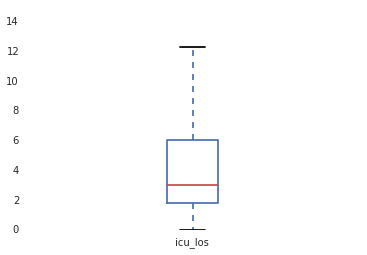

In [126]:
df_icustay_infect['icu_los'].plot(kind='box', ylim=[0, 15])

#### Partition: Training & Testing Sets

In [127]:
data7 = df_icustay_infect[:3000].copy()

train_idx7 = data_partition(data7, 0.70)
train_data7 = data7.ix[train_idx7]
test_idx7 = data7.index[data7.index.isin(train_idx7)==False]
test_data7 = data7.ix[test_idx7]

train_data7.shape, test_data7.shape

((648, 40), (338, 40))

#### Drop Arbitrary Identifiers
Drop `subjectid`, `hadmid`, and `icustayid` that serve only for the purpose of identification.

In [128]:
train_data7.drop(['subjectid','hadmid', 'icustayid'], axis=1, inplace=True)
test_data7.drop(['subjectid','hadmid', 'icustayid'], axis=1, inplace=True)

train_data7.dropna(inplace=True)
test_data7.dropna(inplace=True)

X_train7 = train_data7.iloc[:, :-1]
X_test7 = test_data7.iloc[:, :-1]
y_train7 = np.array(train_data7.iloc[:, -1])
y_test7 = np.array(test_data7.iloc[:, -1])
X_train7.shape, X_test7.shape, y_train7.shape, y_test7.shape

((641, 36), (338, 36), (641,), (338,))

#### Normalization

In [129]:
scaler7 = StandardScaler().fit(X_train7) # scaler object fitted to training set

# Transform
scaled_X_train7 = scaler7.transform(X_train7)
scaled_X_test7 = scaler7.transform(X_test7)

scaled_X_train7.shape, scaled_X_test7.shape, y_train7.shape, y_test7.shape

((641, 36), (338, 36), (641,), (338,))

## Model: Random Forest

#### Criterion
  1. **mse**: mean squared error
  2. **mae**: mean absolute error

In [130]:
rf_model7, rf_pred7, rf_p7, rf_score7, rf_imp7 = rf_gridsearch(scaled_X_train7, scaled_X_test7, y_train7)
print "Best Parameters: ", rf_p7
print "Best Grid Search Score: ", rf_score7
print "Best Estimator: ", rf_model7

Best Parameters:  {'n_estimators': 10, 'criterion': 'mse'}
Best Grid Search Score:  -0.108340064938
Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=2,
           verbose=0, warm_start=False)


### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [131]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test7, rf_pred7))

RMSE = 2.774 days


In [132]:
print "[%.2f,%.2f]" % (y_test7.min(), y_test7.max())

[0.01,28.74]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [133]:
print " MAE = %.3f" % mean_absolute_error(y_test7, rf_pred7)

 MAE = 1.510


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [134]:
print "r2 = %.3f" % r2_score(y_test7, rf_pred7)

r2 = 0.745


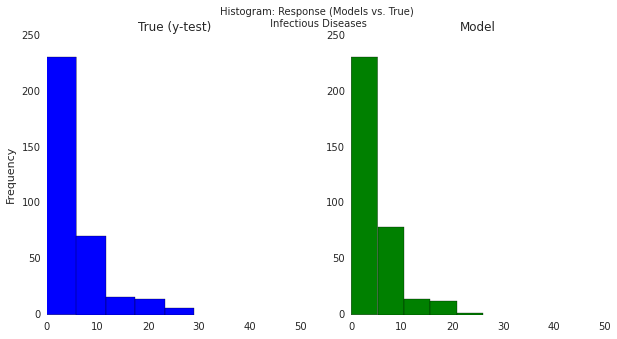

In [230]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.hist(np.round(y_test7), bins=5, color='b')
plt.title("True (y-test)")
plt.ylabel('Frequency')
plt.xlim(x_lim)
plt.ylim([0,250])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(rf_pred7), bins=5, color='g')
plt.title("Model")
plt.xlim(x_lim)
plt.ylim([0,250])
plt.legend(loc='upper right')

plt.suptitle('Histogram: Response (Models vs. True) \n Infectious Diseases')

plt.show()

### Error Visualization: MAE

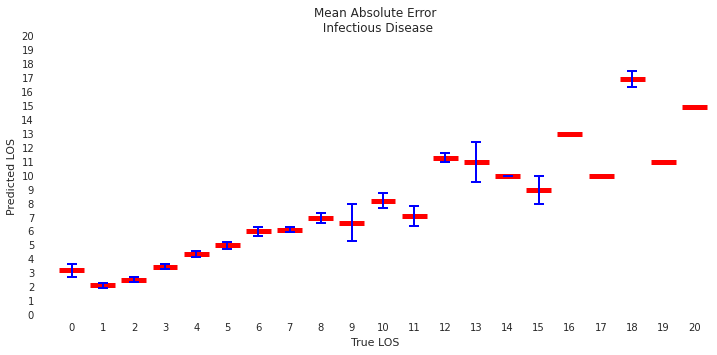

In [233]:
df_rfpred7 = pd.Series(rf_pred7, name="pred").round()
df_true7 = pd.Series(y_test7, name = "true").round()

df_rfresults7 = pd.concat([df_true7, df_rfpred7], axis=1)
rf_residual7 = pd.Series(df_rfresults7['true'].sub(df_rfresults7['pred'], axis=0).abs(), name='resid')
df_rfresults7 = pd.concat([df_rfresults7, rf_residual7], axis=1)

rf_errort7 = df_rfresults7[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

# Error Plot
plt.figure(figsize=(12,5))
plt.bar(left=[i for i in rf_errort7.index.tolist()], 
        height=[0]*len(rf_errort7), 
        width=0.8, 
        bottom=rf_errort7[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=rf_errort7[['pred']].values[:,2] / rf_errort7[['pred']].values[:,-1] ** 0.5,  # error: standard deviation
        orientation='vertical',
        error_kw=dict(ecolor='blue', lw=2, capsize=5, capthick=2))
    
plt.xlabel('True LOS')
plt.xticks(rf_errort7.index)
plt.yticks(rf_errort7.index)
plt.ylabel('Predicted LOS')
plt.xlim([-1,20.5])
plt.ylim([0,20])
plt.title('Mean Absolute Error \n Infectious Disease')

plt.show()

## Other

In [136]:
df_icustay_other = df_icustay_f[df_icustay_f['drg_code'].isin(cdv)==False]
df_icustay_other = df_icustay_f[df_icustay_f['drg_code'].isin(resp_surg_lst)==False]
df_icustay_other = df_icustay_f[df_icustay_f['drg_code'].isin(resp_med_lst)==False]
# df_icustay_other = df_icustay_f[df_icustay_f['drg_code'].isin(muscoskeletal_surg_lst)==False]
# df_icustay_other = df_icustay_f[df_icustay_f['drg_code'].isin(muscoskeletal_med_lst)==False]
df_icustay_other = df_icustay_f[df_icustay_f['drg_code'].isin(nerv_surg_lst)==False]
df_icustay_other = df_icustay_f[df_icustay_f['drg_code'].isin(nerv_med_lst)==False]
df_icustay_other = df_icustay_f[df_icustay_f['drg_code'].isin(infectious)==False]

df_icustay_other.shape

(13292, 40)

In [137]:
df_icustay_other['icu_los'].describe()

count    13292.000000
mean         4.797033
std          7.127835
min          0.000300
25%          1.376050
50%          2.534100
75%          5.035000
max        173.072500
Name: icu_los, dtype: float64

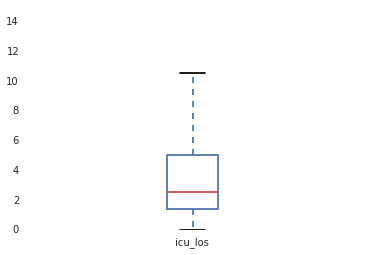

In [138]:
df_icustay_other['icu_los'].plot(kind='box', ylim=[0, 15])

#### Partition: Training & Testing Sets

In [139]:
data8 = df_icustay_other[:3000].copy()

train_idx8 = data_partition(data8, 0.70)
train_data8 = data8.ix[train_idx8]
test_idx8 = data8.index[data8.index.isin(train_idx8)==False]
test_data8 = data8.ix[test_idx8]

train_data8.shape, test_data8.shape

((2104, 40), (902, 40))

#### Drop Arbitrary Identifiers
Drop `subjectid`, `hadmid`, and `icustayid` that serve only for the purpose of identification.

In [140]:
train_data8.drop(['subjectid','hadmid', 'icustayid'], axis=1, inplace=True)
test_data8.drop(['subjectid','hadmid', 'icustayid'], axis=1, inplace=True)

train_data8.dropna(inplace=True)
test_data8.dropna(inplace=True)

In [141]:
X_train8 = train_data8.iloc[:, :-1]
X_test8 = test_data8.iloc[:, :-1]
y_train8 = np.array(train_data8.iloc[:, -1])
y_test8 = np.array(test_data8.iloc[:, -1])
X_train8.shape, X_test8.shape, y_train8.shape, y_test8.shape

((2098, 36), (902, 36), (2098,), (902,))

#### Normalization

In [142]:
scaler8 = StandardScaler().fit(X_train8) # scaler object fitted to training set

# Transform
scaled_X_train8 = scaler8.transform(X_train8)
scaled_X_test8 = scaler8.transform(X_test8)

scaled_X_train8.shape, scaled_X_test8.shape, y_train8.shape, y_test8.shape

((2098, 36), (902, 36), (2098,), (902,))

## Model: Random Forest

#### Criterion
  1. **mse**: mean squared error
  2. **mae**: mean absolute error

In [143]:
rf_model8, rf_pred8, rf_p8, rf_score8, rf_imp8 = rf_gridsearch(scaled_X_train8, scaled_X_test8, y_train8)
print "Best Parameters: ", rf_p8
print "Best Grid Search Score: ", rf_score8
print "Best Estimator: ", rf_model8

Best Parameters:  {'n_estimators': 10, 'criterion': 'mae'}
Best Grid Search Score:  0.0700811810226
Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=2,
           verbose=0, warm_start=False)


### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [144]:
print "RMSE = %.3f days" % np.sqrt(mean_squared_error(y_test8, rf_pred8))

RMSE = 6.069 days


In [145]:
print "[%.2f,%.2f]" % (y_test8.min(), y_test8.max())

[0.00,68.03]


#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [146]:
print " MAE = %.3f" % mean_absolute_error(y_test8, rf_pred8)

 MAE = 2.838


#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [147]:
print "r2 = %.3f" % r2_score(y_test8, rf_pred8)

r2 = 0.537


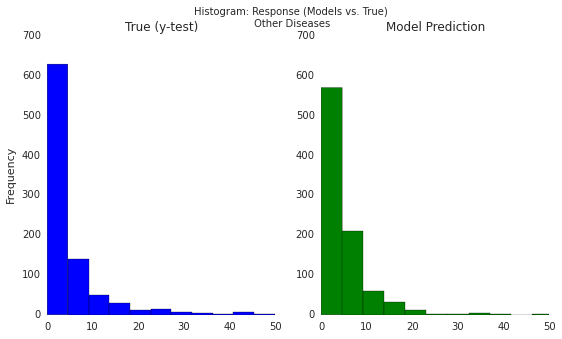

In [238]:
plt.figure(figsize=(9, 5))
plt.subplot(1,2,1)
plt.hist(np.round(y_test8), bins=15, color='b')
plt.title("True (y-test)")
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0,700])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(rf_pred8), bins=13, color='g')
plt.title("Model Prediction")
plt.xlim([0,50])
plt.ylim([0,700])
plt.legend(loc='upper right')

plt.suptitle('Histogram: Response (Models vs. True) \n Other Diseases')

plt.show()

### Error Visualization: MAE

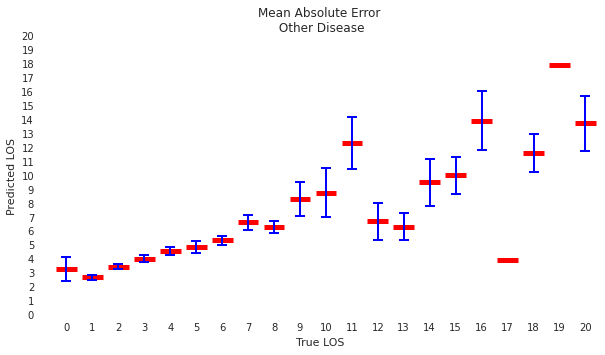

In [241]:
df_rfpred8 = pd.Series(rf_pred8, name="pred").round()
df_true8 = pd.Series(y_test8, name = "true").round()

df_rfresults8 = pd.concat([df_true8, df_rfpred8], axis=1)
rf_residual8 = pd.Series(df_rfresults8['true'].sub(df_rfresults8['pred'], axis=0).abs(), name='resid')
df_rfresults8 = pd.concat([df_rfresults8, rf_residual8], axis=1)

rf_errort8 = df_rfresults8[['true', 'pred']].groupby('true').agg([np.mean, np.median, np.std, np.max, np.min, 'count'])

# Error Plot
plt.figure(figsize=(10,5))
plt.bar(left=[i for i in rf_errort8.index.tolist()], 
        height=[0]*len(rf_errort8), 
        width=0.8, 
        bottom=rf_errort8[['pred']].values[:,0], # mean of predictions
        linewidth=5, edgecolor='r', align='center',
        yerr=rf_errort8[['pred']].values[:,2] / rf_errort8[['pred']].values[:,-1] ** 0.5,  # error: standard deviation
        orientation='vertical',
        error_kw=dict(ecolor='blue', lw=2, capsize=5, capthick=2))
    
plt.xlabel('True LOS')
plt.xticks(rf_errort8.index)
plt.yticks(rf_errort8.index)
plt.ylabel('Predicted LOS')
plt.xlim([-1,20.5])
plt.ylim([0,20])
plt.title('Mean Absolute Error \n Other Disease')

plt.show()

## Conclusion
**Background**: The DRG classification system was originally developed to identify the "products" patients received. The healthcare industry has evolved and developed an increased demand for a classification system at a higher level of precision. As a result, *multiple branches* of the DRG system has expanded to serve various purposes.

MIMIC-III dataset does not only use 1 of these systems, but a variety. Thus, creating inconsistencies as a numerical DRG code varies between each branch/system.

**Notes**: 
  * Other category is mainly based on those diseases have very little sample size and insufficient to be a category on their own.
  * Further stratification by *surgery/medical* is only possible due to the reimbursement nature of DRG codes. Classification by pathology may not be feasible due to how diseases are grouped. Specificity may be loss if a medicine-centric stratification was pursued.

### Main Points
1. As previously discovered, **Random Forest** yields the best metrics in terms of error estimates (**RMSE** & **MAE**) and goodness-of-fit (**R<sup>2</sup>**). This is most likely attributed to the *bagging* component of its ensemble learning.
2. Further stratifying (*surgical/medical*) the *manual* classification of patients by major disease categories yielded 
   * no improvements in metrics for **Heart Disease**, **Infectious Disease**, & **Musculoskeletal System**
   * some improvements for **Respiratory Disease** and **Nervous System Disease**, though only the *surgical* and *medical* sub-groups respectively
   * **Musculoskeletal Diseases** appear to be irrelevant in comparison to other groups (*poor metrics*)

### Results
<table>
  <tr>
    <th rowspan="2" colspan="1"> </th>
    <th rowspan="1", colspan="2">Heart Disease</th>
    <th rowspan="1", colspan="2">Respiratory Disease</th> 
    <th rowspan="1", colspan="2">Musculoskeletal Disease</th>
    <th rowspan="1", colspan="2">Nervous System Disease</th>
    <th rowspan="1", colspan="2">Infectious Diseases</th>
    <th rowspan="2", colspan="1">Others</th>
    <th rowspan="2", colspan="1">Average</th>
  </tr>
  <tr>
    <td>Surgical</td>
    <td>Medical</td> 
    <td>Surgical</td>
    <td>Medical</td> 
    <td>Surgical</td>
    <td>Medical</td> 
    <td>Surgical</td>
    <td>Medical</td> 
    <td>Surgical</td>
    <td>Medical</td>
  </tr>
  <tr>
    <td>**RMSE**</td>
    <td>3.3</td>
    <td>2.9</td> 
    <td>2.6</td>
    <td>5.1</td> 
    <td>5.7</td>
    <td>4.6</td> 
    <td>4.2</td>
    <td>7.4</td> 
    <td>8.8</td>
    <td>3.1</td>
    <td>6.1</td>
    <td>4.9</td>
  </tr>
  <tr>
    <td>**MAE**</td>
    <td>1.8</td>
    <td>2.9</td> 
    <td>1.7</td>
    <td>2.0</td> 
    <td>3.2</td>
    <td>2.5</td> 
    <td>2.3</td>
    <td>4.3</td> 
    <td>3.8</td>
    <td>1.6</td>
    <td>2.9</td>
    <td>2.5</td>
  </tr>
  <tr>
    <td>**R<sup>2</sup>**</td>
    <td>0.55</td>
    <td>0.58</td> 
    <td>0.87</td>
    <td>0.47</td> 
    <td>-0.12</td>
    <td>0.23</td> 
    <td>-0.15</td>
    <td>0.54</td> 
    <td>0.26</td>
    <td>0.68</td>
    <td>0.54</td>
    <td>0.46</td>
  </tr>
</table>

### Summary
In conclusion, **Random Forest** sub-models should be created for these categories to yield optimal results:
  * Disease Category by Organ System
    * **Heart Disease**
    * **Infectious Disease**
  * Sub-stratification (*surgical + medical*)
    * **Respiratory Disease** (*surgical only*)
    * **Nervous System Diseases** (*medical only*)


It should be noted that the high variation within the Nervous System Disease and Musculoskeletal groups may be due to the high variation in the severity of the diseases that they encompass, which may make their models appropriate to include.


<table>
  <tr>
    <th rowspan="2" colspan="1"> </th>
    <th rowspan="2", colspan="1">Heart Disease</th>
    <th rowspan="1", colspan="2">Respiratory Disease</th> 
    <th rowspan="1", colspan="2">Nervous System Disease</th>
    <th rowspan="2", colspan="1">Infectious Diseases</th>
    <th rowspan="2", colspan="1">Others</th>
    <th rowspan="2", colspan="1">Average</th>
  </tr>
  <tr>
    <td>Surgical</td>
    <td>Medical</td>  
    <td>Surgical</td>
    <td>Medical</td> 
  </tr>
  <tr>
    <td>**RMSE**</td>
    <td>2.4</td>
    <td>2.6</td>
    <td>5.1</td> 
    <td>4.2</td>
    <td>7.4</td> 
    <td>2.8</td>
    <td>6.1</td>
    <td>4.3</td>
  </tr>
  <tr>
    <td>**MAE**</td>
    <td>1.3</td> 
    <td>1.7</td>
    <td>2.0</td> 

    <td>2.3</td>
    <td>4.3</td> 
    <td>1.5</td>
    <td>2.9</td>
    <td>2.3</td>
  </tr>
  <tr>
    <td>**R<sup>2</sup>**</td>
    <td>0.71</td>
    <td>0.87</td>
    <td>0.47</td> 
    <td>-0.15</td>
    <td>0.54</td> 
    <td>0.75</td>
    <td>0.54</td>
    <td>0.68</td>
  </tr>
</table>